# Plots with beta

In [1]:
import pickle
import sys
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import os
import pandas as pd
import datetime
import matplotlib.ticker as ticker
sys.path.append("../../")
sys.path.append("../../covid19_inference")
sys.path.append("../")

import covid19_soccer
from covid19_soccer.plot.utils import get_from_trace
import covid19_inference as cov19
from header_plotting import *
import seaborn as sns

In [2]:
%load_ext autoreload
%autoreload 2

In [12]:
def load(fstr):
    with open(fstr, "rb") as f:
         return pickle.load(f)

countries = ['England', 'Scotland', 'Spain', 'Germany', 'Italy', 'Netherlands']
traces, models, dls = [], [], []
for country in tqdm(countries):
    #'UEFA-beta=False-country=England-offset_games=0-draw_delay=True-weighted_alpha_prior=0-prior_delay=-1-width_delay_prior=0.1-sigma_incubation=-1.0-median_width_delay=1.0-tune=200-draws=300-max_treedepth=10.pickled'
    model = None
    fstr=lambda tune, draws, max_treedepth: (f"/data.nst/share/soccer_project/covid_uefa_traces14/run"+
        f"-beta=True"+
        f"-country={country}"+
        f"-offset_data=0"+
        f"-prior_delay=-1"+
        f"-median_width_delay=1.0"+
        f"-interval_cps=10.0"+
        f"-f_fem=0.33"+
        f"-len=normal"+
        f"-abs_sine=False"+
        f"-t={tune}"+
        f"-d={draws}"+
        f"-max_treedepth={max_treedepth}.pkl")
    dl = covid19_soccer.dataloader.Dataloader_gender(countries=[country])
    dls.append(dl)
    #print(fstr(4000, 8000, 12))
    if os.path.exists(fstr(4000, 8000, 12)):
        try:
            model, trace = load(fstr(4000, 8000, 12))
            print(f"Use 8000 sample runs for {country}")
        except:
            pass
    if model is None and os.path.exists(fstr(2000, 4000, 12)):
        try:
            model, trace = load(fstr(2000, 4000, 12))
            print(f"Use 4000 sample runs for {country}")
        except:
            pass
    if model is None and os.path.exists(fstr(1000, 1500, 12)):
        try: 
            model, trace = load(fstr(1000, 1500, 12))
            print(f"Use 1500 sample runs for {country}")
        except:
            pass
    if model is None and os.path.exists(fstr(500, 1000, 12)):
        try: 
            model, trace = load(fstr(500, 1000, 12))
            print(f"Use 1000 sample runs for {country}")
        except:
            pass
    if model is None:
        print(country+" not found")
        continue
    
    # Remove chains with likelihood larger than -200, should only be the case for 2 chains in France
    mask = (np.mean(trace.sample_stats.lp, axis=1)>-200)
    trace.posterior = trace.posterior.sel(chain=~mask)
    
    models.append(model)
    traces.append(trace)
    

  0%|          | 0/6 [00:00<?, ?it/s]

Use 4000 sample runs for England
Use 1000 sample runs for Scotland
Use 4000 sample runs for Spain
Use 4000 sample runs for Germany
Use 4000 sample runs for Italy
Use 4000 sample runs for Netherlands


In [13]:
import copy
tr_spain = copy.deepcopy(traces[2])
tr_spain.posterior = tr_spain.posterior.where((tr_spain.posterior["delay"]>5.5).any(axis=-1))

traces_edited = copy.deepcopy(traces)
traces_edited[2] = tr_spain

In [ ]:
# Plotting
from covid19_soccer.plot.other import soccer_related_cases_overview, legend
import string

fig, axes  = plt.subplots(1, 2,figsize=(7,2.5),gridspec_kw={"wspace":0.25})

soccer_related_cases_overview(
    axes[0],
    traces_edited,
    models,
    dls,
    vertical=True,
    plot_flags=False,
    remove_outliers=True,
    country_order=[0,1,2,3,4,5],
)
axes[0].set_xlim(-35,35)
axes[0].set_xlabel("Primary cases gatherings (% of all observed\ncases, from 11th June to 31st July) ")
axes[0].set(yticklabels=[])
axes[0].tick_params(left=False)

soccer_related_cases_overview(
    axes[1],
    traces_edited,
    models,
    dls,
    plot_betas=True,
    vertical=True,
    plot_flags=True,
    ypos_flags=-35,
    flags_zoom=0.025,
    country_order=[0,1,2,3,4,5],
)
axes[1].set_xlim(-35,35)
axes[1].set_xlabel("Primary cases stadium (% of all observed\ncases, from 11th June to 31st July) ")
legend(axes[1],
    prior=False,
    posterior=False,
    model=False,
    data=False,
    sex=True,
    disable_axis=False,
    championship_range=False,
    loc=1
)

#Add axes annotations
alphabet_string = list(string.ascii_uppercase)
for i, ax in enumerate(axes):
    letter = alphabet_string[i]
    ax.text(0.05, 1.1, letter, transform=ax.transAxes,
            fontsize=8, fontweight='bold', va='top', ha='right')


plt.show()
fig_path = "../figures/SI"
fig.savefig(f"{fig_path}/beta.pdf", **save_kwargs)
fig.savefig(f"{fig_path}/beta.png", **save_kwargs)
plt.close(fig=fig)

In [ ]:
# Plotting
from covid19_soccer.plot.other import soccer_related_cases_overview, legend
import string
from covid19_soccer.plot.rcParams import *
from covid19_soccer.plot.utils import lighten_color
# Adjust colors
color_male = lighten_color(rcParams.color_male,0.5)
color_female = lighten_color(rcParams.color_female,0.5)



fig, axes  = plt.subplots(1, 2,figsize=(7,2.5),gridspec_kw={"wspace":0.25})

soccer_related_cases_overview(
    axes[0],
    traces,
    models,
    dls,
    vertical=True,
    plot_flags=False,
    remove_outliers=True,
    country_order=[0,1,2,3,4,5],
    alpha=0.5,
    colors=[color_male,color_female]
)
axes[0].set_xlim(-35,35)
axes[0].set_xlabel("Fraction of primary cases\n(gatherings)")
axes[0].set(yticklabels=[])
axes[0].tick_params(left=False)

soccer_related_cases_overview(
    axes[1],
    traces,
    models,
    dls,
    plot_betas=True,
    vertical=True,
    plot_flags=True,
    remove_outliers=True,
    ypos_flags=-35,
    flags_zoom=0.025,
    country_order=[0,1,2,3,4,5],
    alpha=0.5,
    colors=[color_male,color_female]
)
axes[1].set_xlim(-35,35)
axes[1].set_xlabel("Fraction of primary cases\n(stadium)")
legend(axes[1],
    prior=False,
    posterior=False,
    model=False,
    data=False,
    sex=True,
    disable_axis=False,
    championship_range=False,
    loc=1
)

#Add axes annotations
alphabet_string = list(string.ascii_uppercase)
for i, ax in enumerate(axes):
    letter = alphabet_string[i]
    ax.text(0.05, 1.1, letter, transform=ax.transAxes,
            fontsize=8, fontweight='bold', va='top', ha='right')


plt.show()
fig_path = "../figures/SI"
fig.savefig(f"{fig_path}/beta_l.pdf", **save_kwargs)
fig.savefig(f"{fig_path}/beta_l.png", **save_kwargs)
plt.close(fig=fig)

INFO     [covid19_inference.data_retrieval.retrieval] Successfully loaded OxCGRT.csv.gz from /tmp/covid19_data/, skipping download.
/home/smohr/Repositories/covid19_soccer/notebooks/supplementary/../../covid19_soccer/plot/other.py:920: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  lines.append(Patch([0], [0], color=rcParams.color_posterior, lw=0,),)


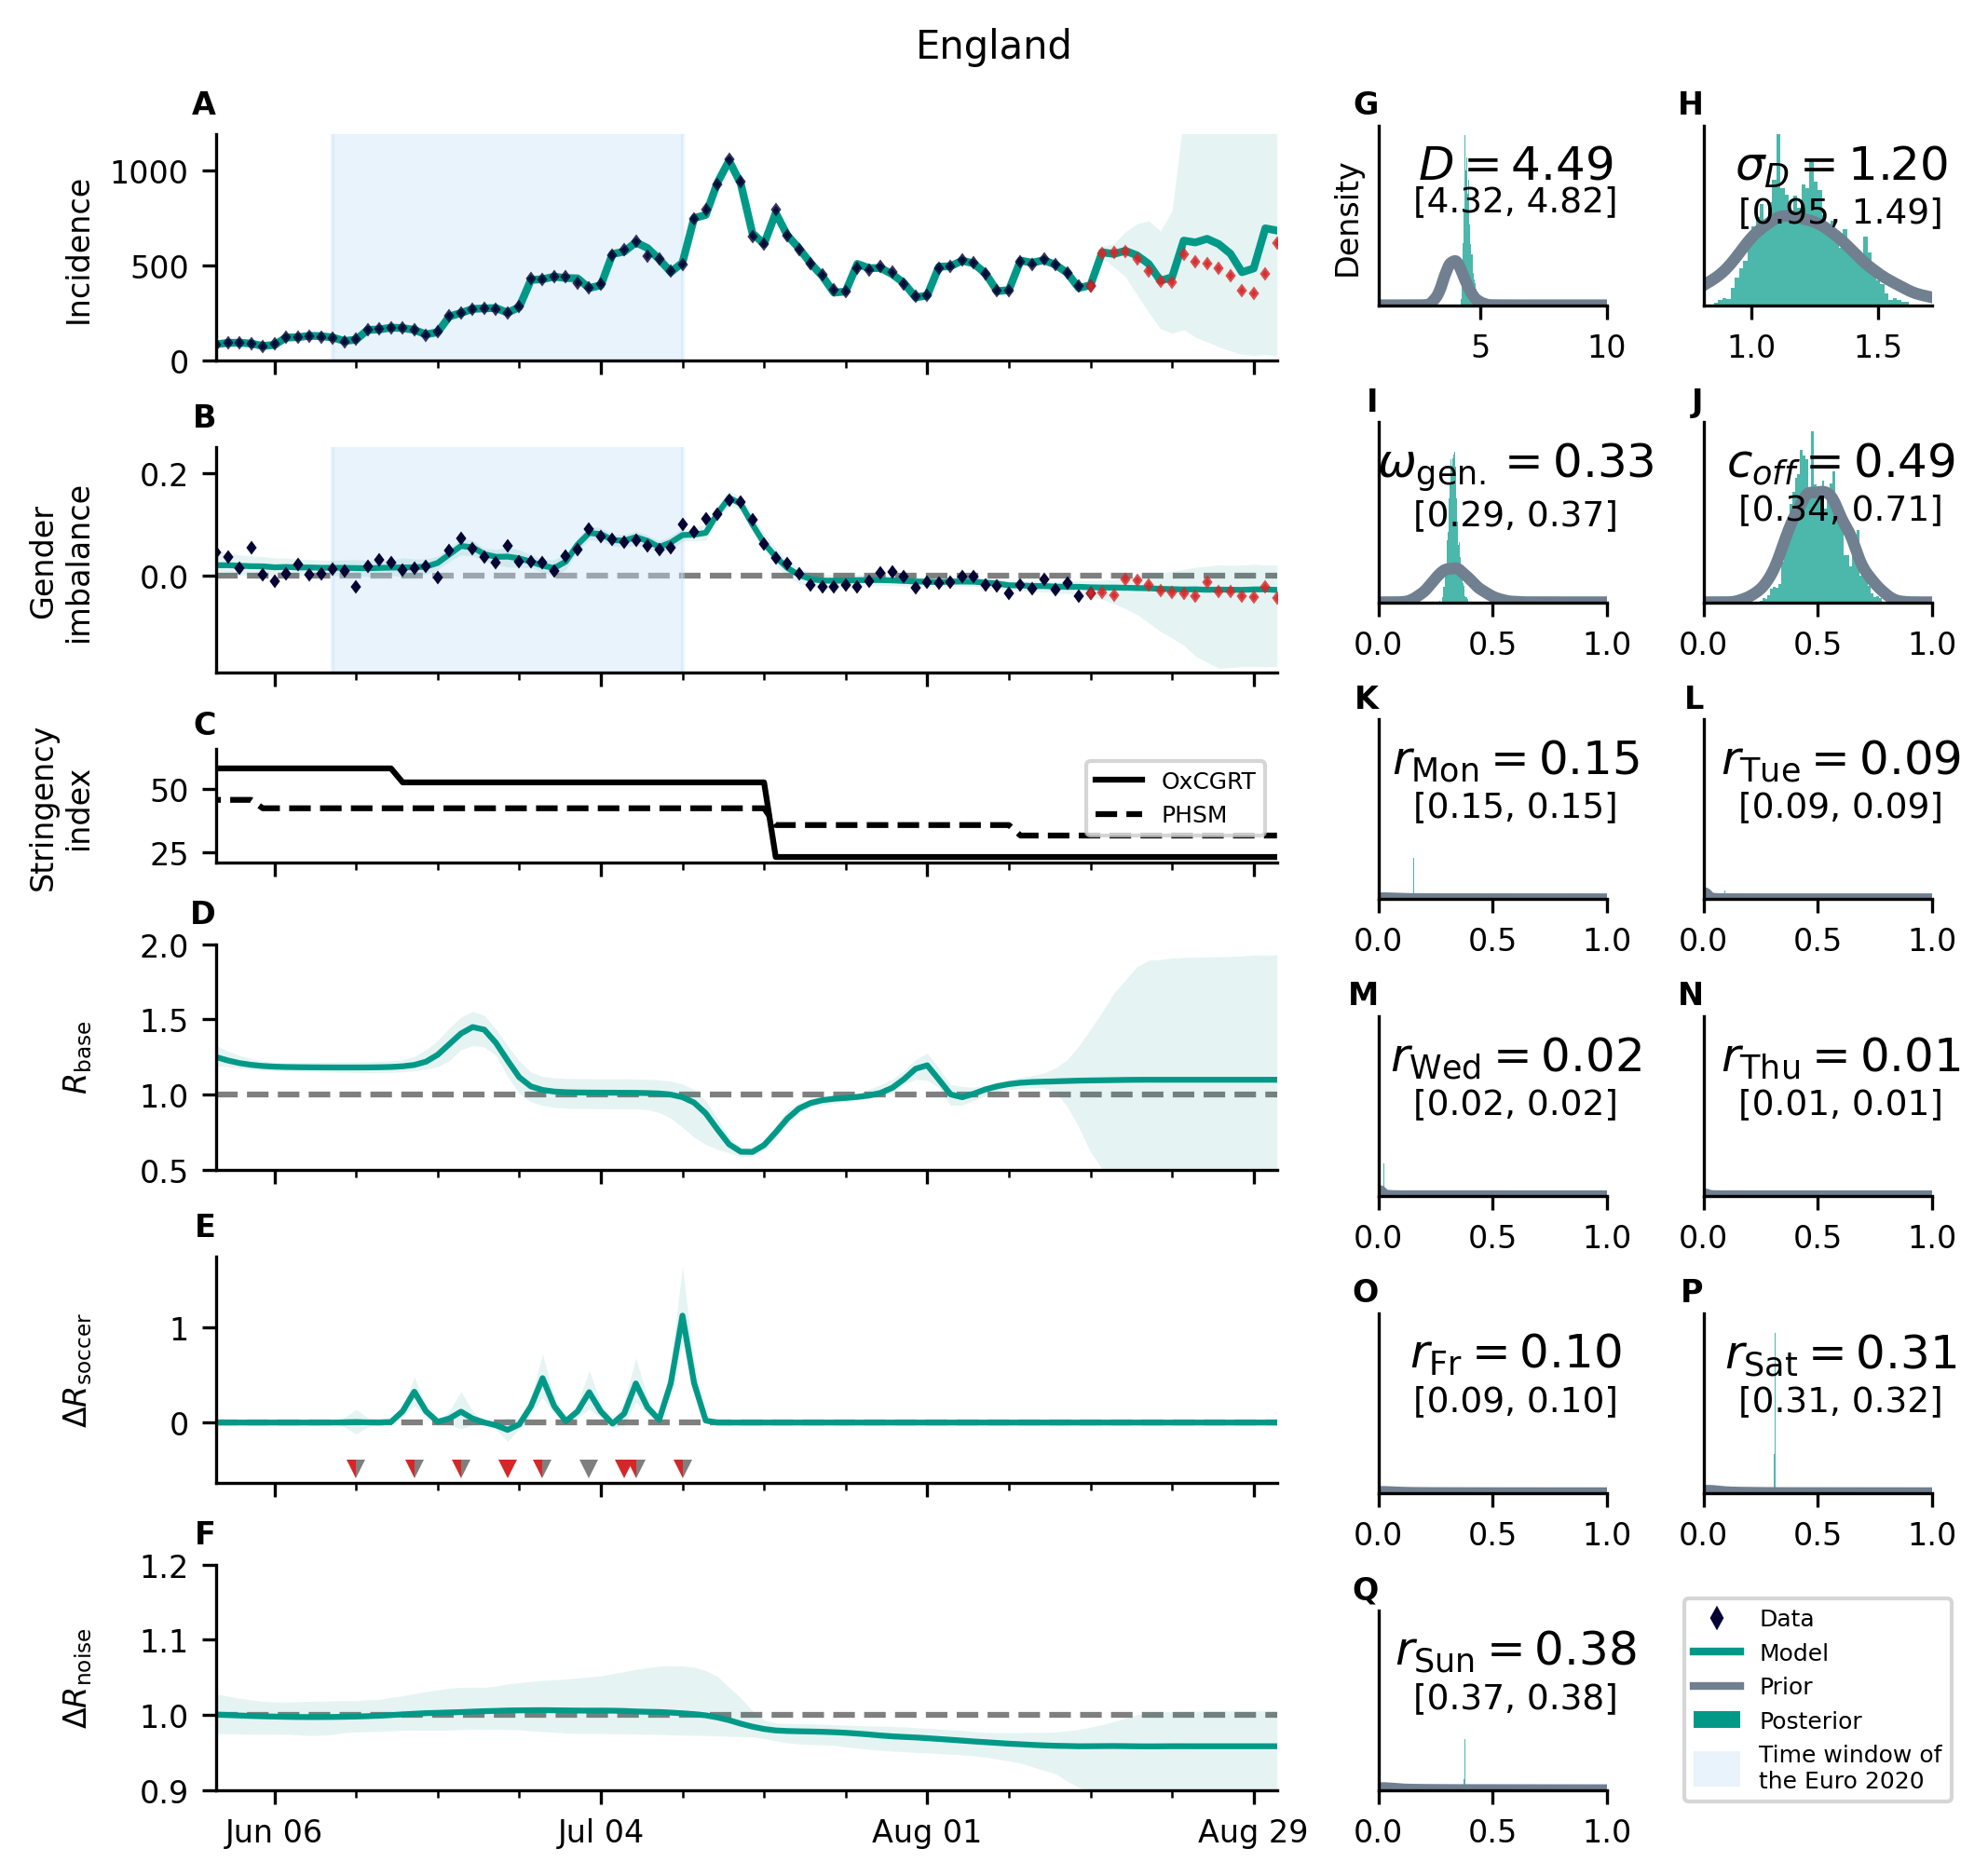

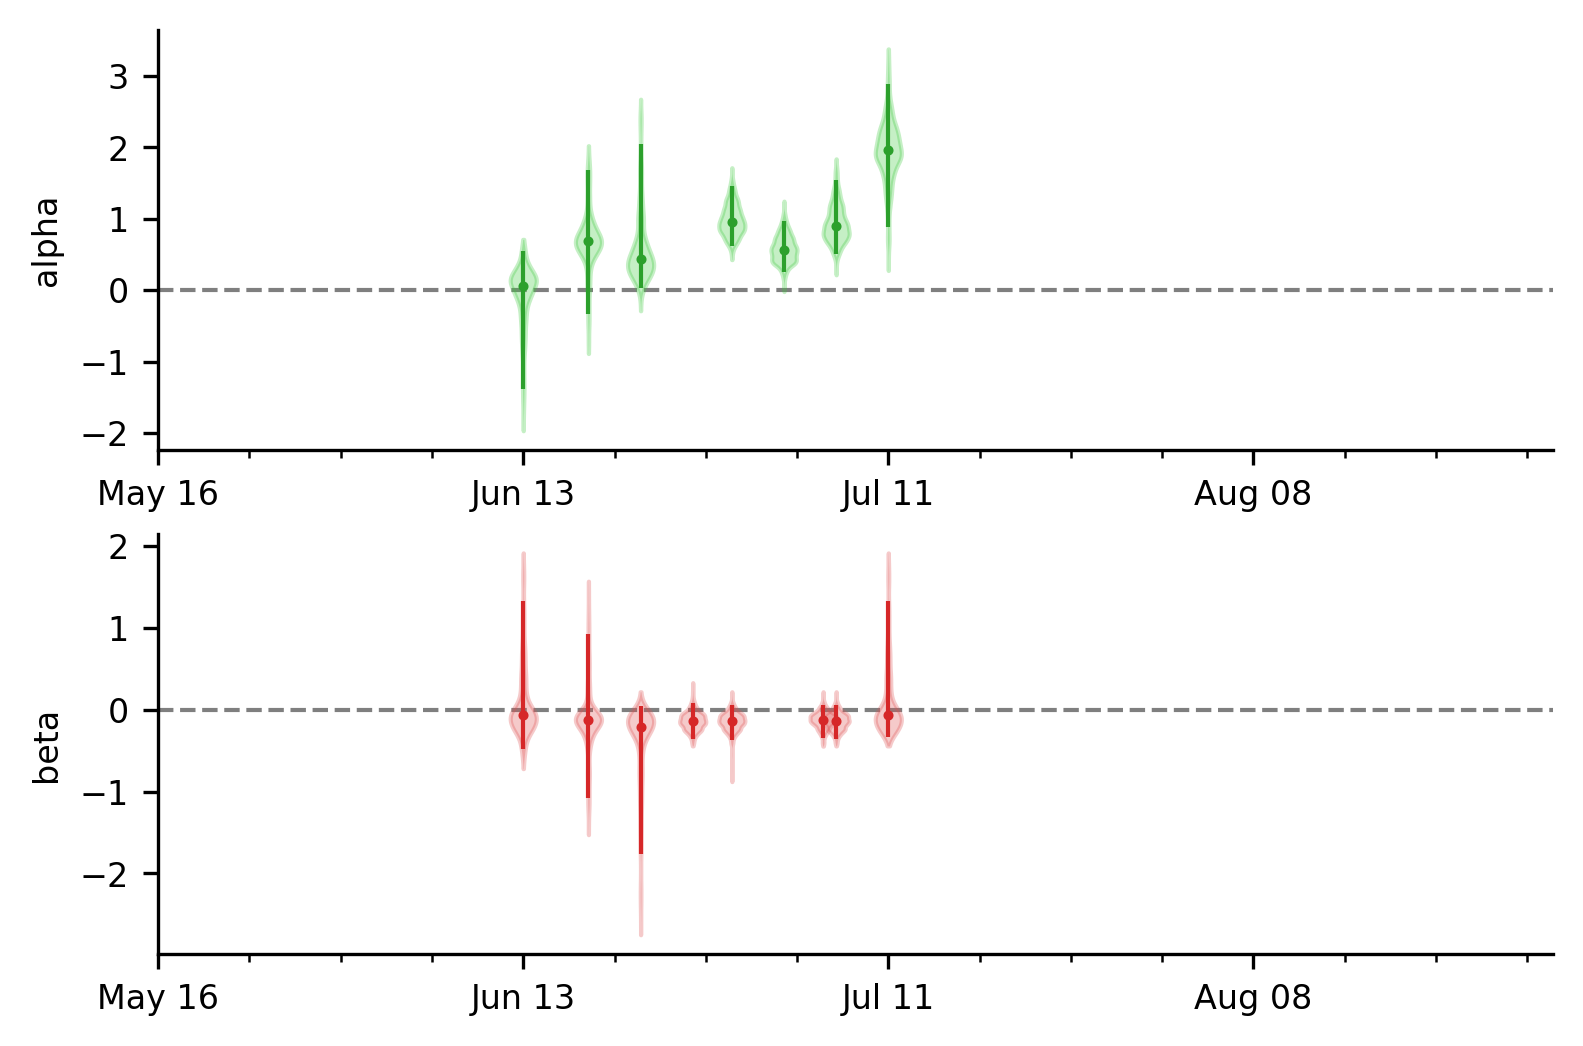

INFO     [covid19_inference.data_retrieval.retrieval] Successfully loaded OxCGRT.csv.gz from /tmp/covid19_data/, skipping download.
/home/smohr/Repositories/covid19_soccer/notebooks/supplementary/../../covid19_soccer/plot/other.py:920: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  lines.append(Patch([0], [0], color=rcParams.color_posterior, lw=0,),)


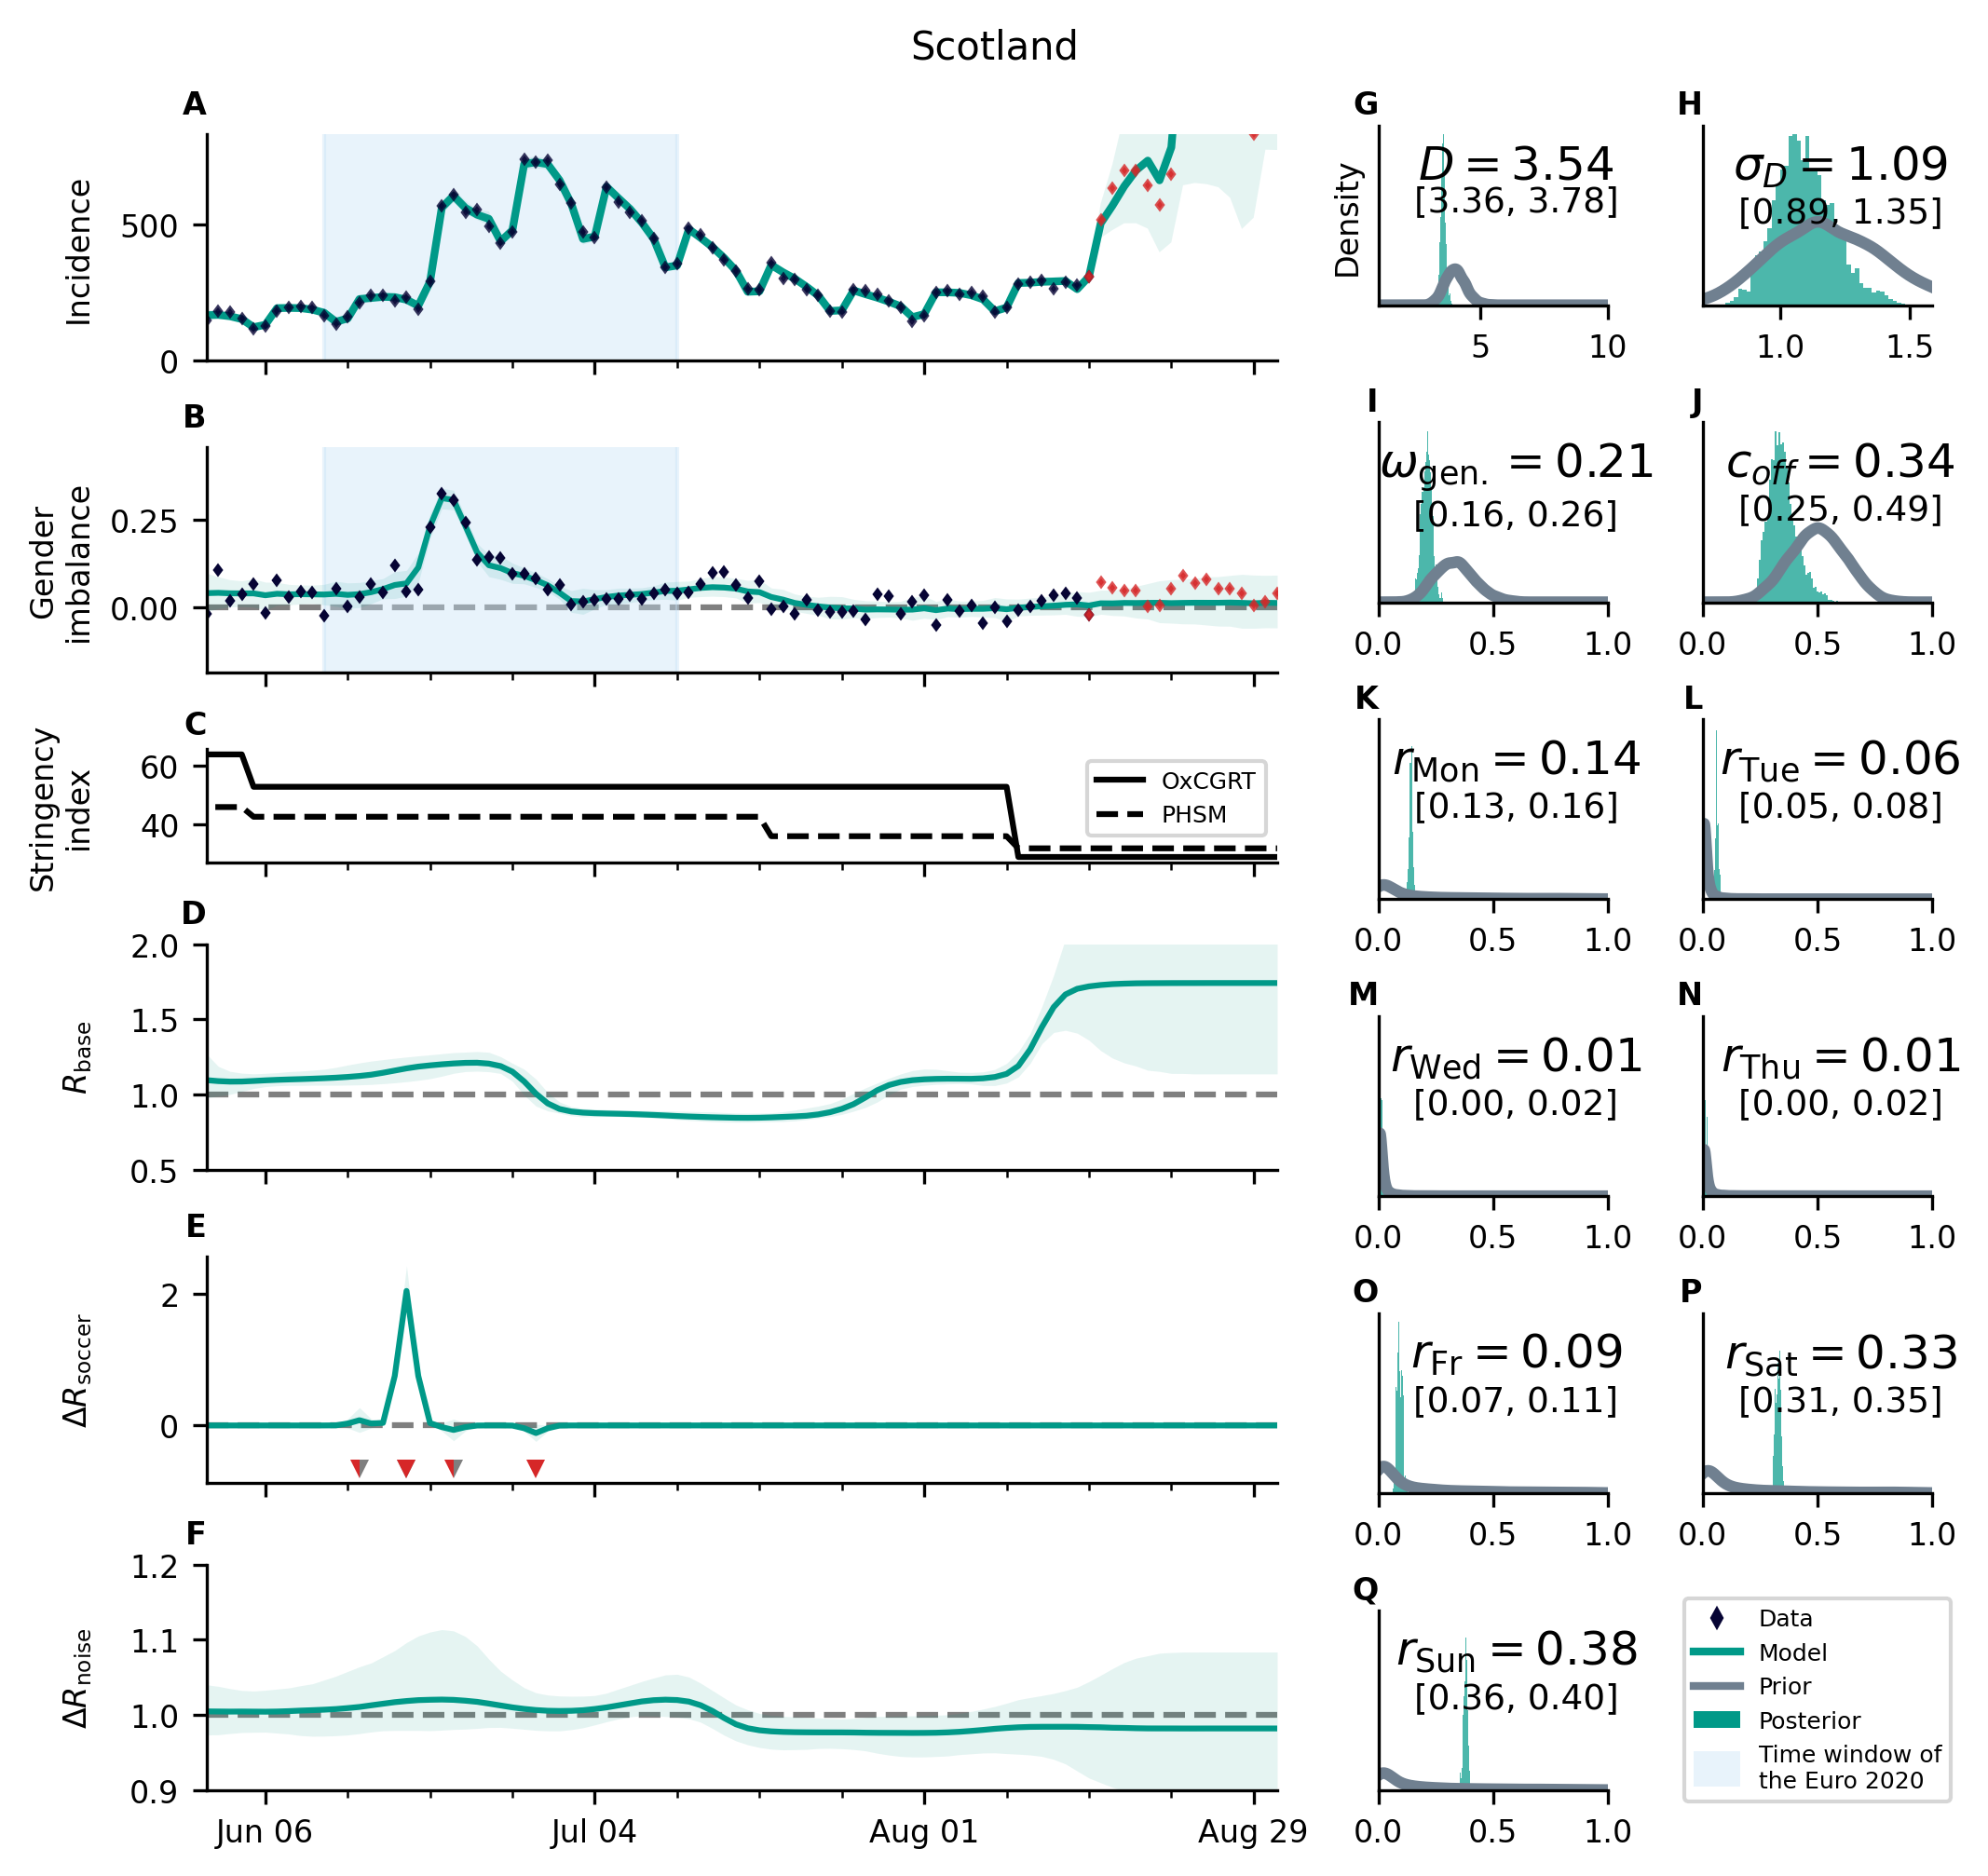

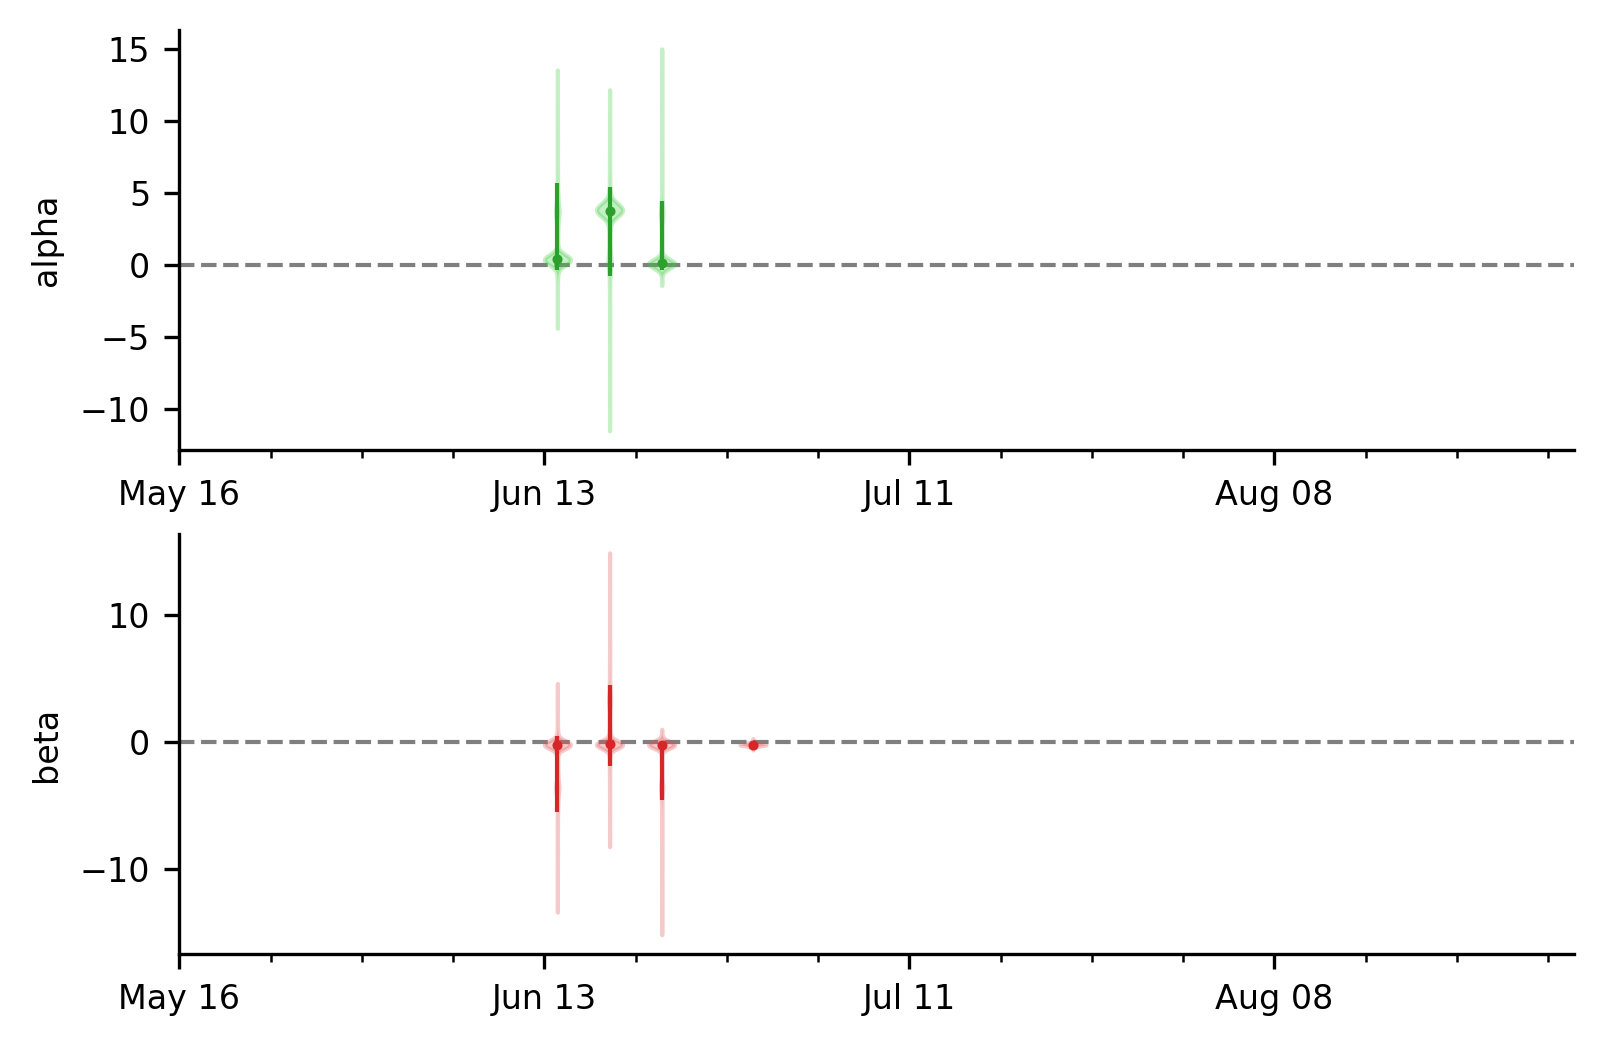

INFO     [covid19_inference.data_retrieval.retrieval] Successfully loaded OxCGRT.csv.gz from /tmp/covid19_data/, skipping download.
/home/smohr/Repositories/covid19_soccer/notebooks/supplementary/../../covid19_soccer/plot/other.py:920: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  lines.append(Patch([0], [0], color=rcParams.color_posterior, lw=0,),)


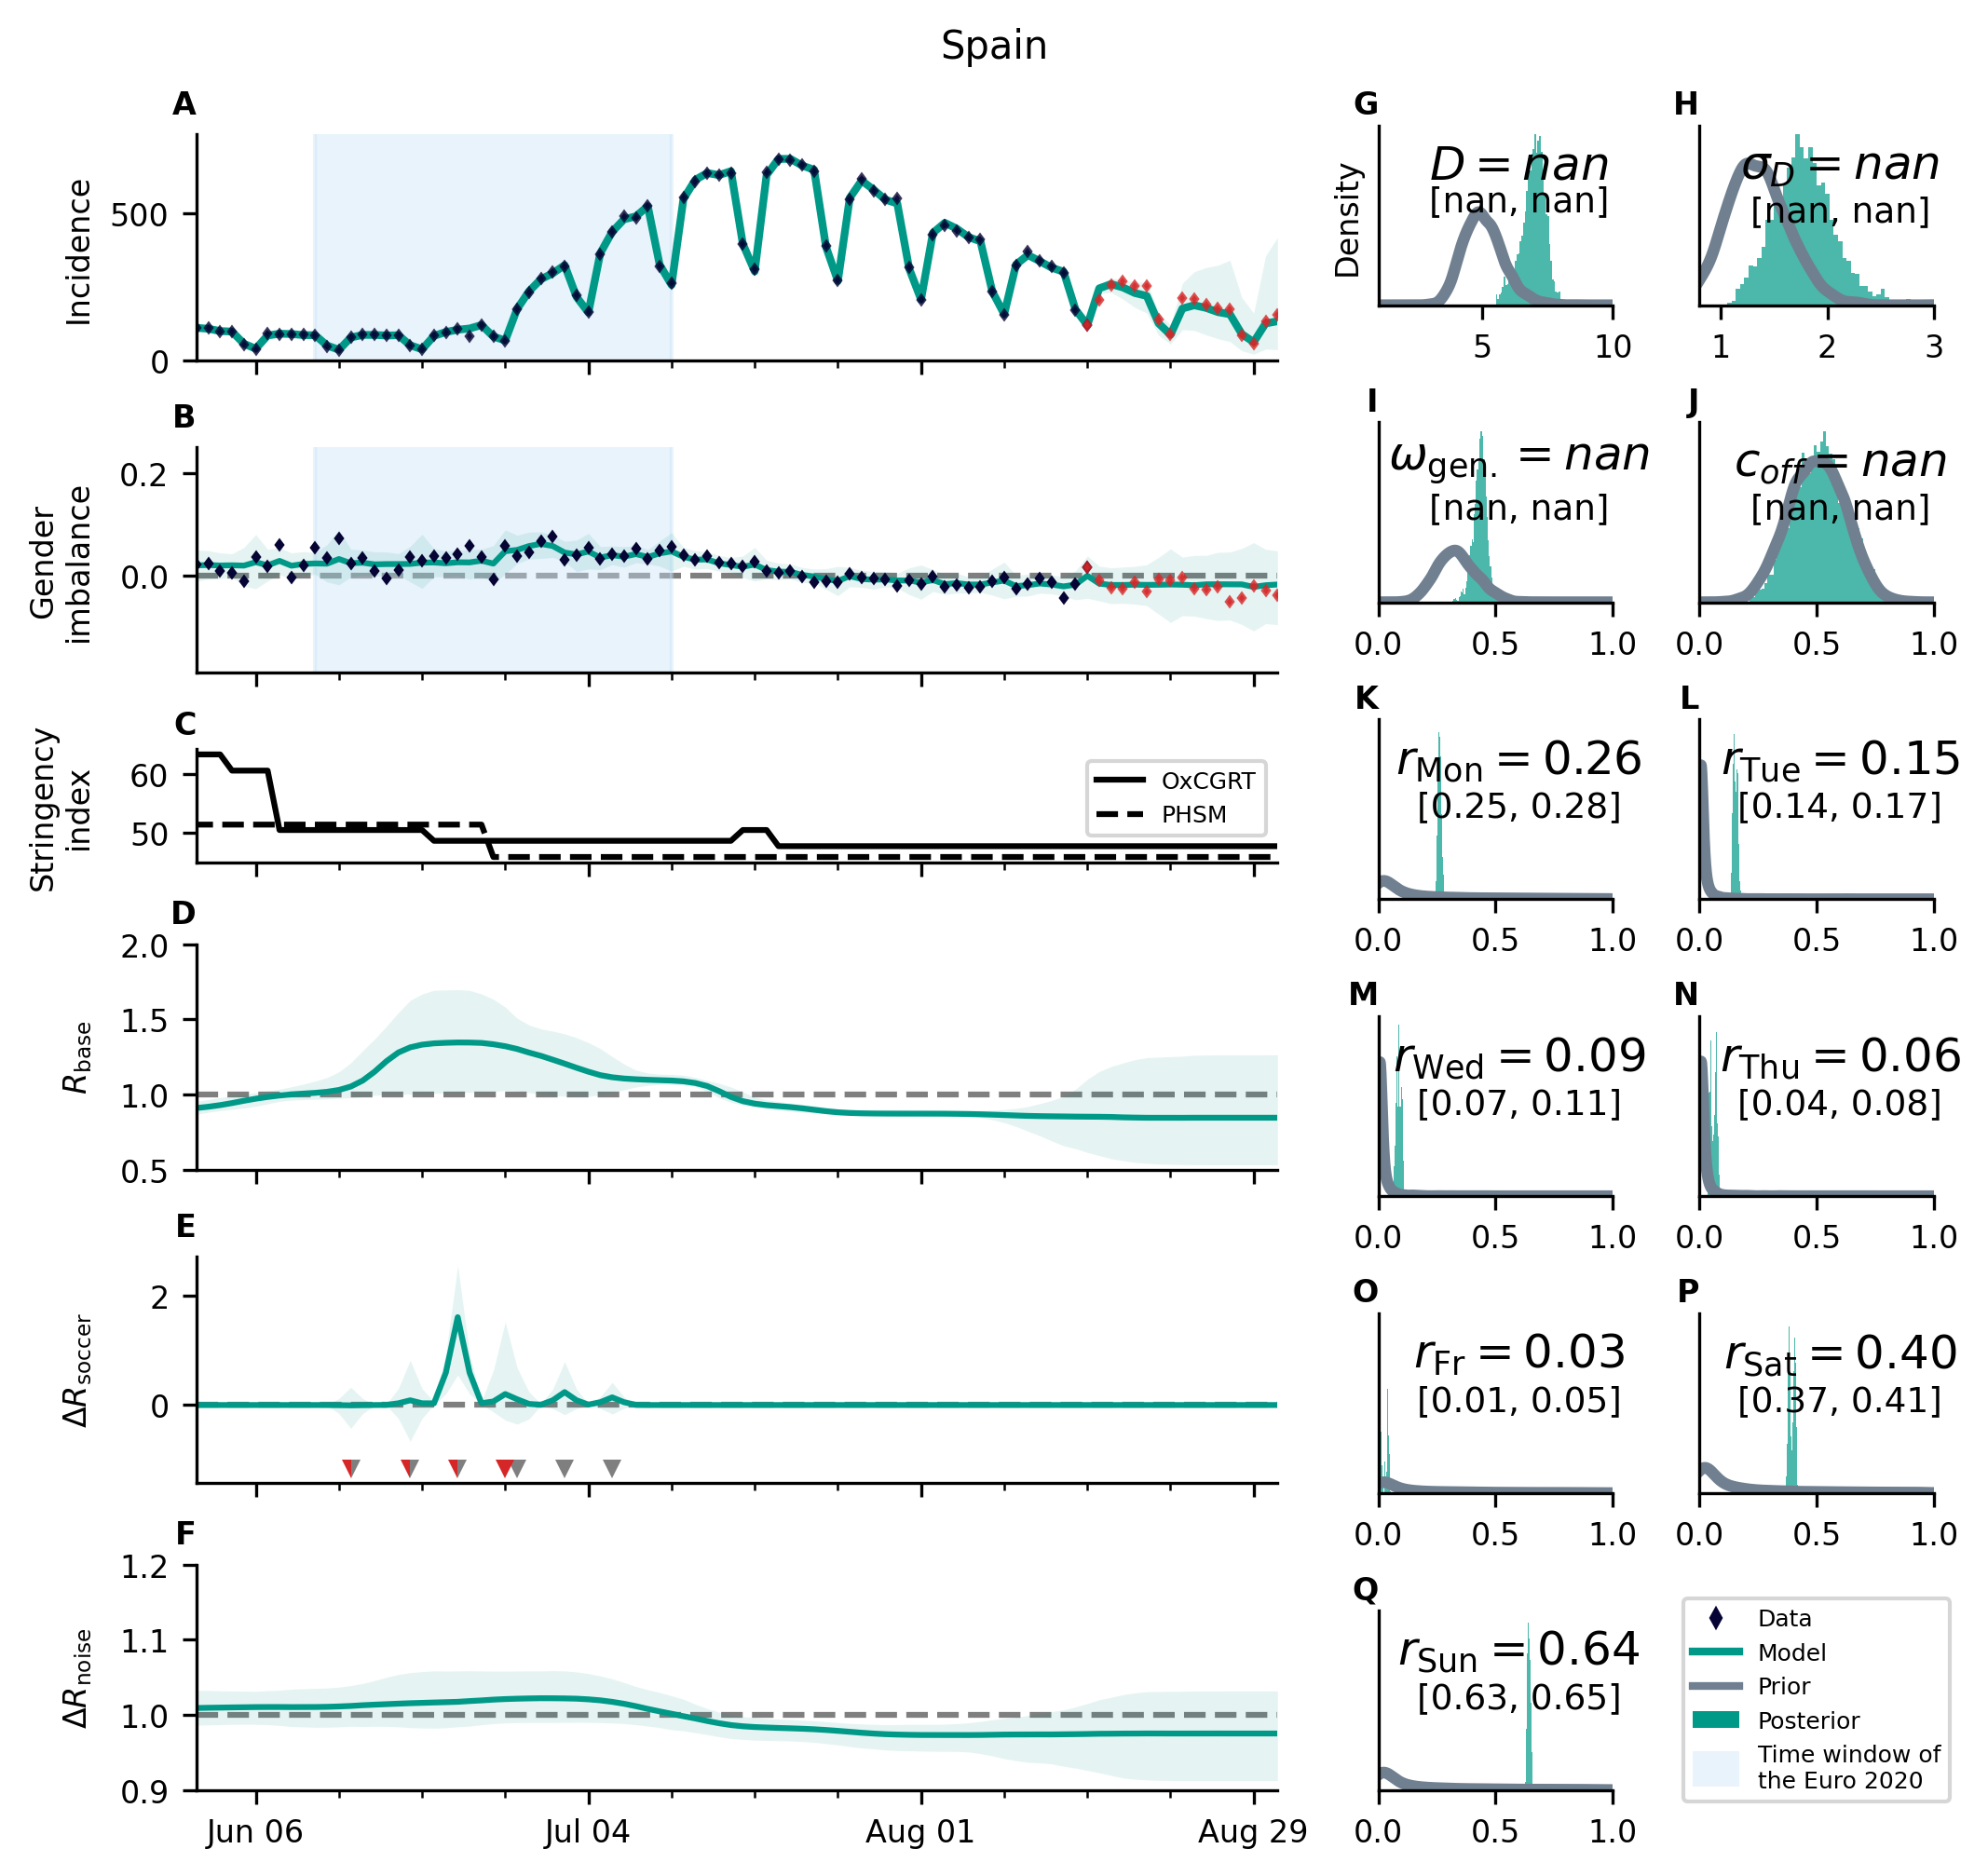

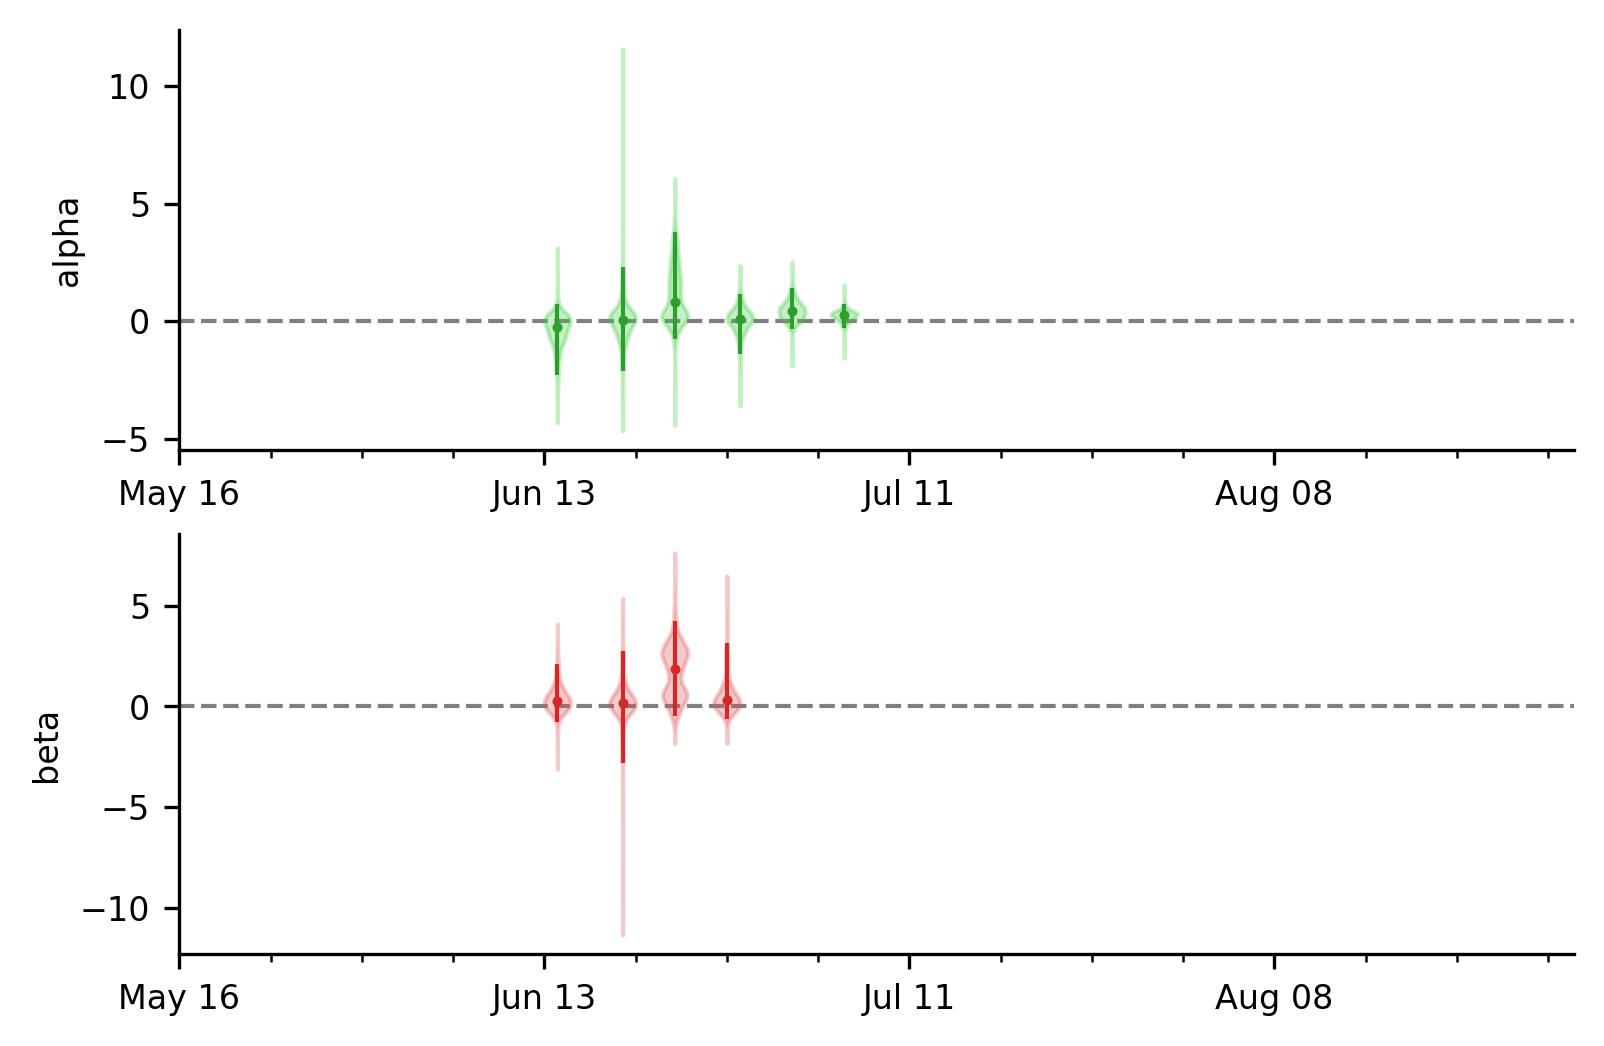

INFO     [covid19_inference.data_retrieval.retrieval] Successfully loaded OxCGRT.csv.gz from /tmp/covid19_data/, skipping download.
/home/smohr/Repositories/covid19_soccer/notebooks/supplementary/../../covid19_soccer/plot/other.py:920: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  lines.append(Patch([0], [0], color=rcParams.color_posterior, lw=0,),)


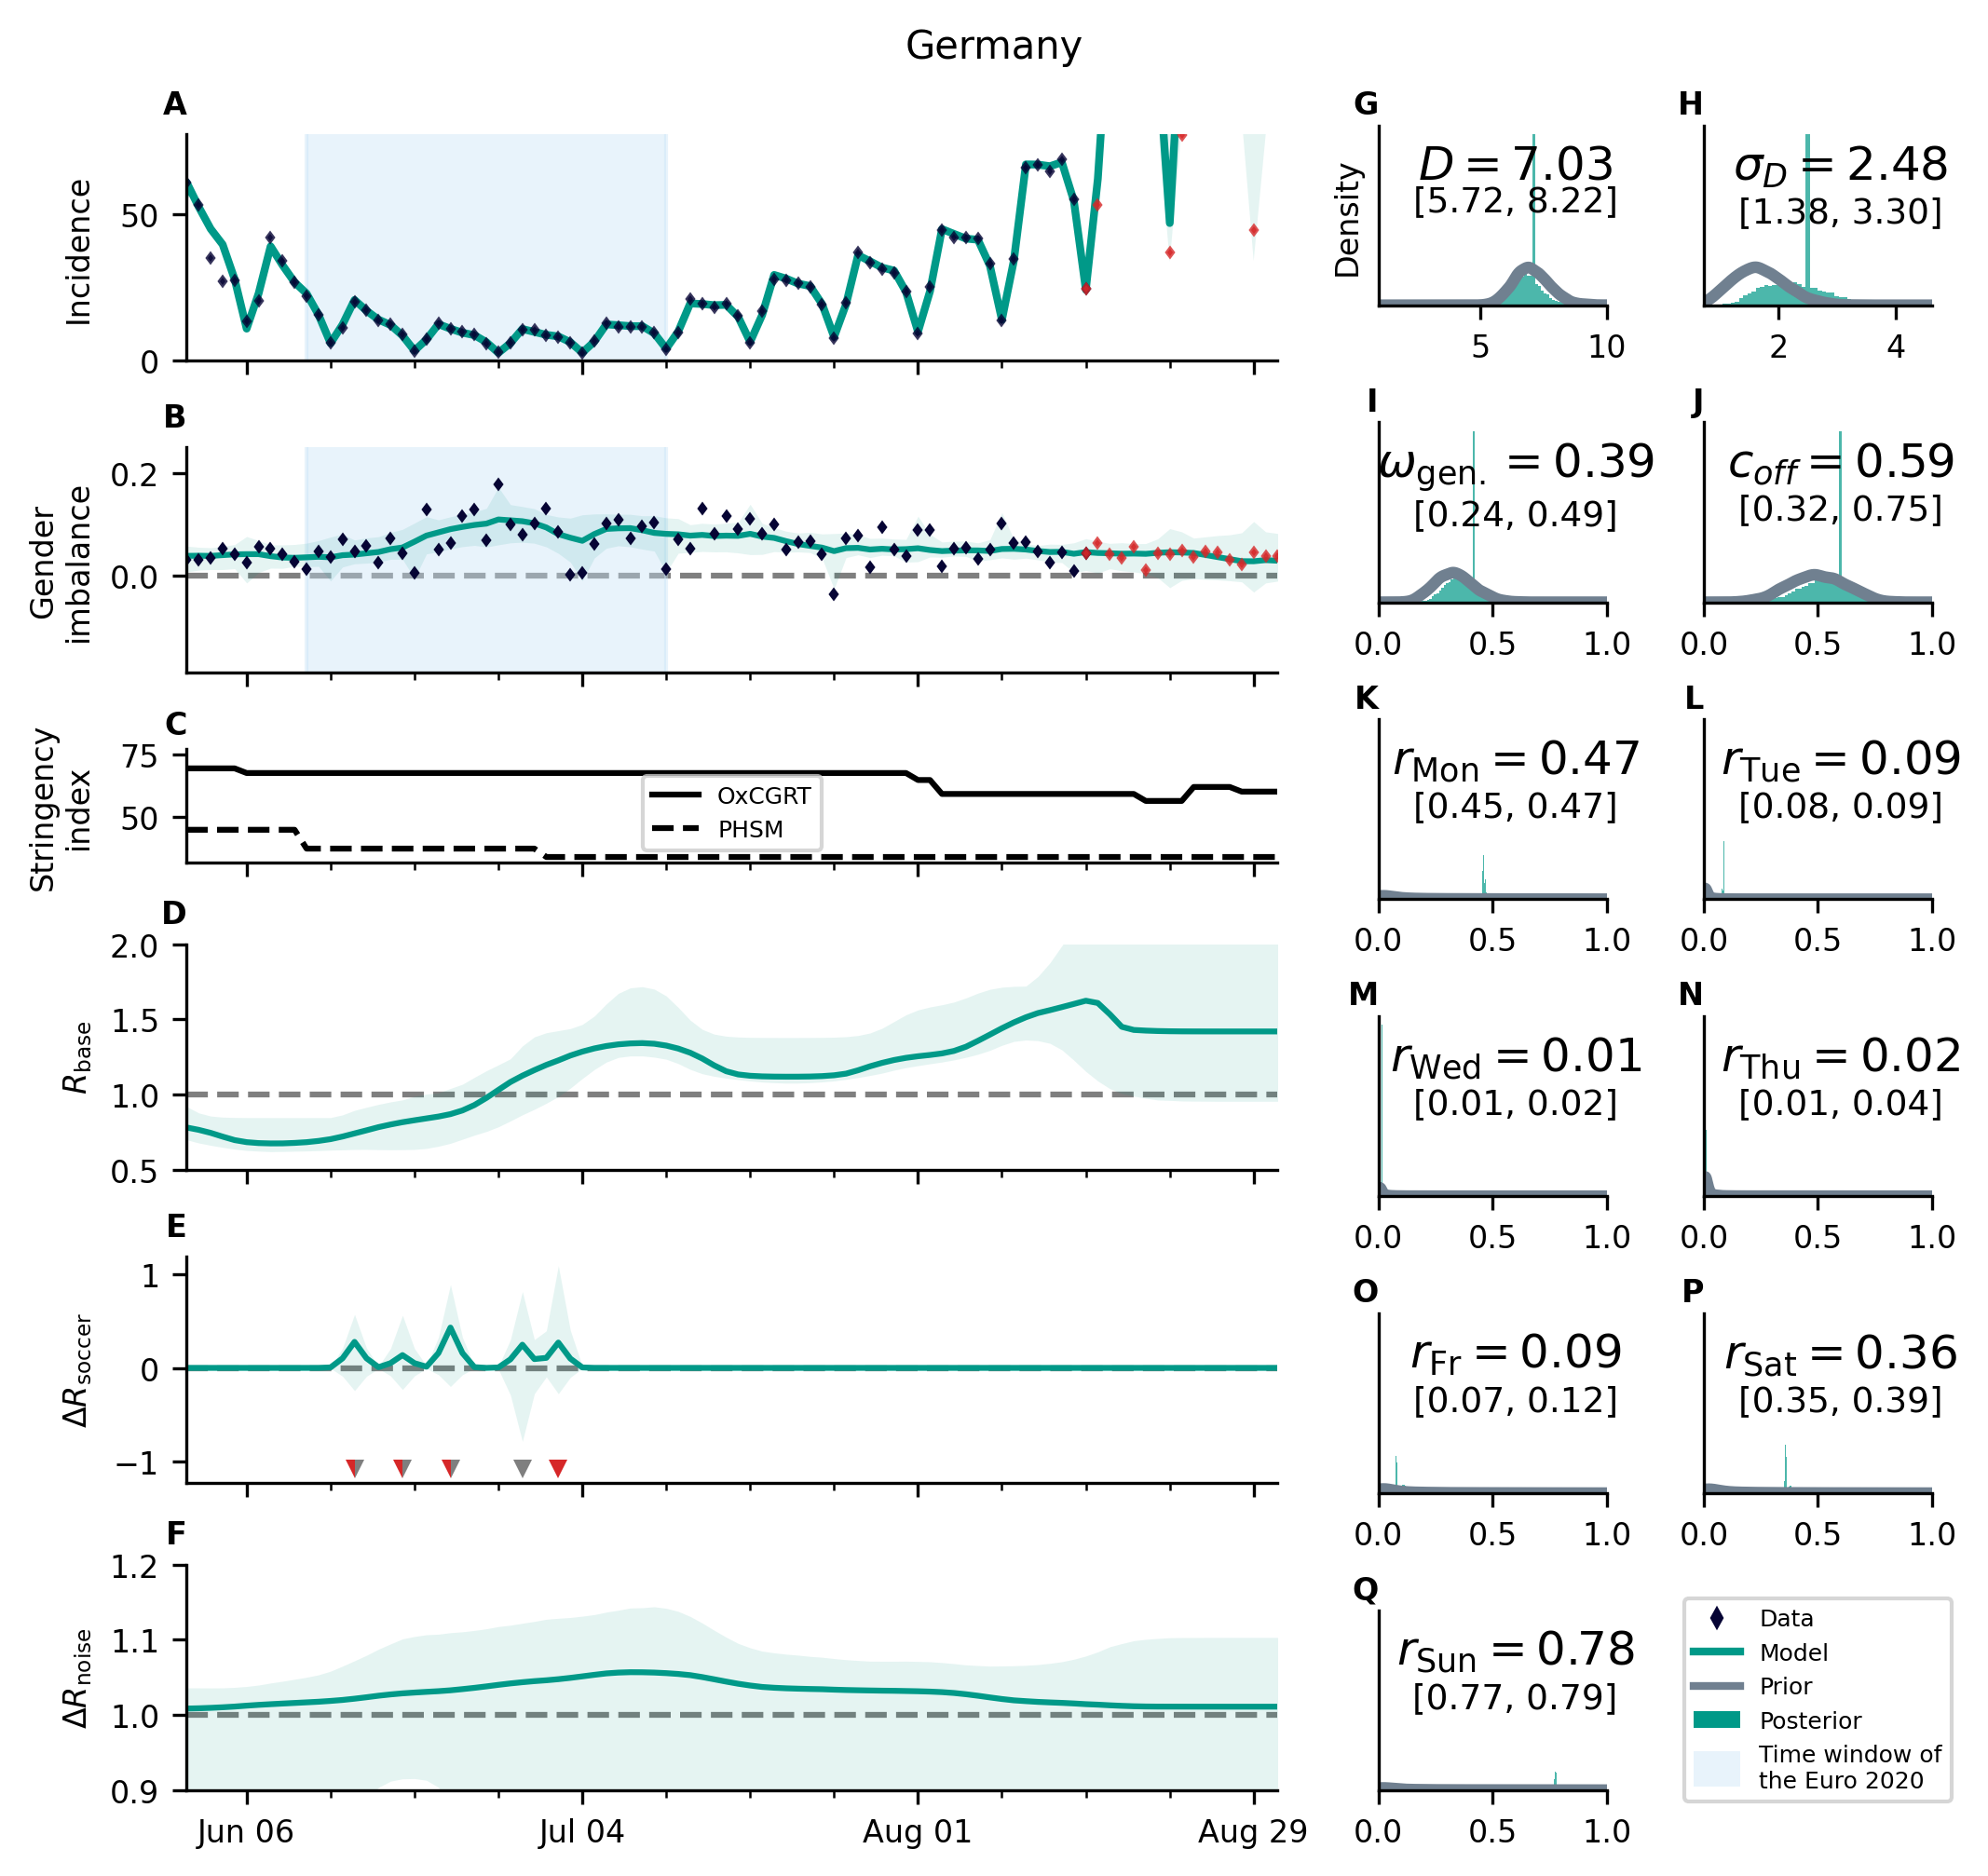

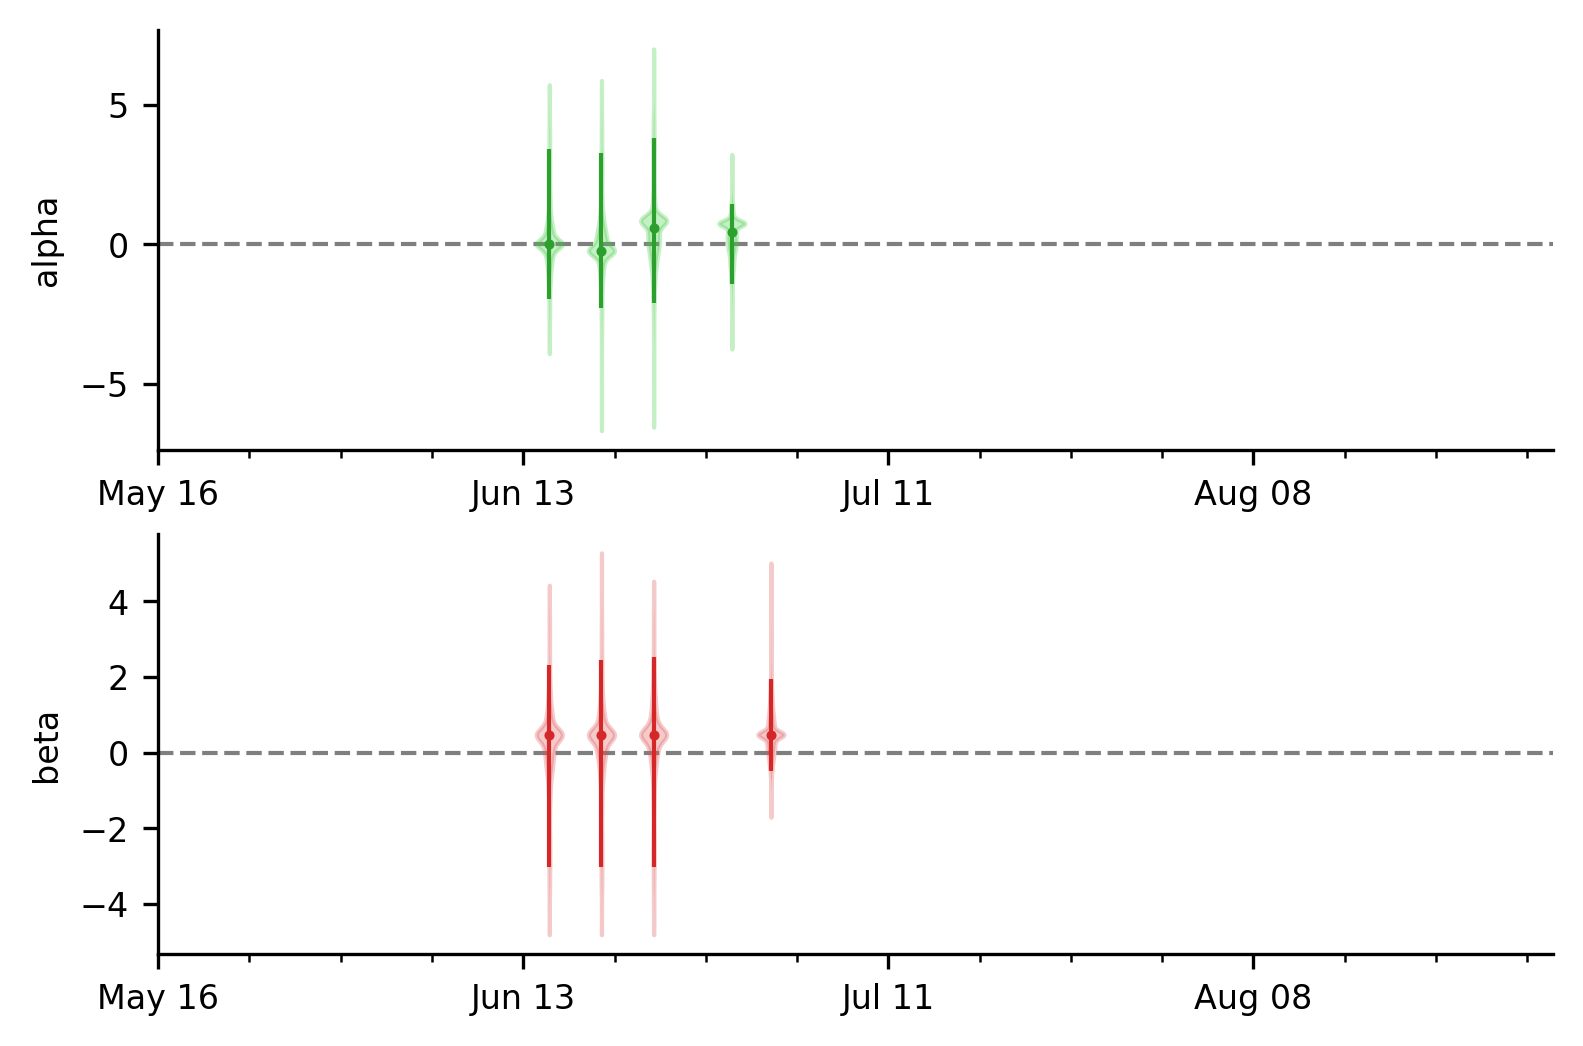

/home/smohr/Repositories/covid19_soccer/notebooks/supplementary/../../covid19_soccer/plot/timeseries.py:155: RuntimeWarning: invalid value encountered in true_divide
  y=(
/home/smohr/Repositories/covid19_soccer/notebooks/supplementary/../../covid19_soccer/plot/timeseries.py:180: RuntimeWarning: invalid value encountered in true_divide
  imbalance = (
INFO     [covid19_inference.data_retrieval.retrieval] Successfully loaded OxCGRT.csv.gz from /tmp/covid19_data/, skipping download.
/home/smohr/Repositories/covid19_soccer/notebooks/supplementary/../../covid19_soccer/plot/other.py:920: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  lines.append(Patch([0], [0], color=rcParams.color_posterior, lw=0,),)


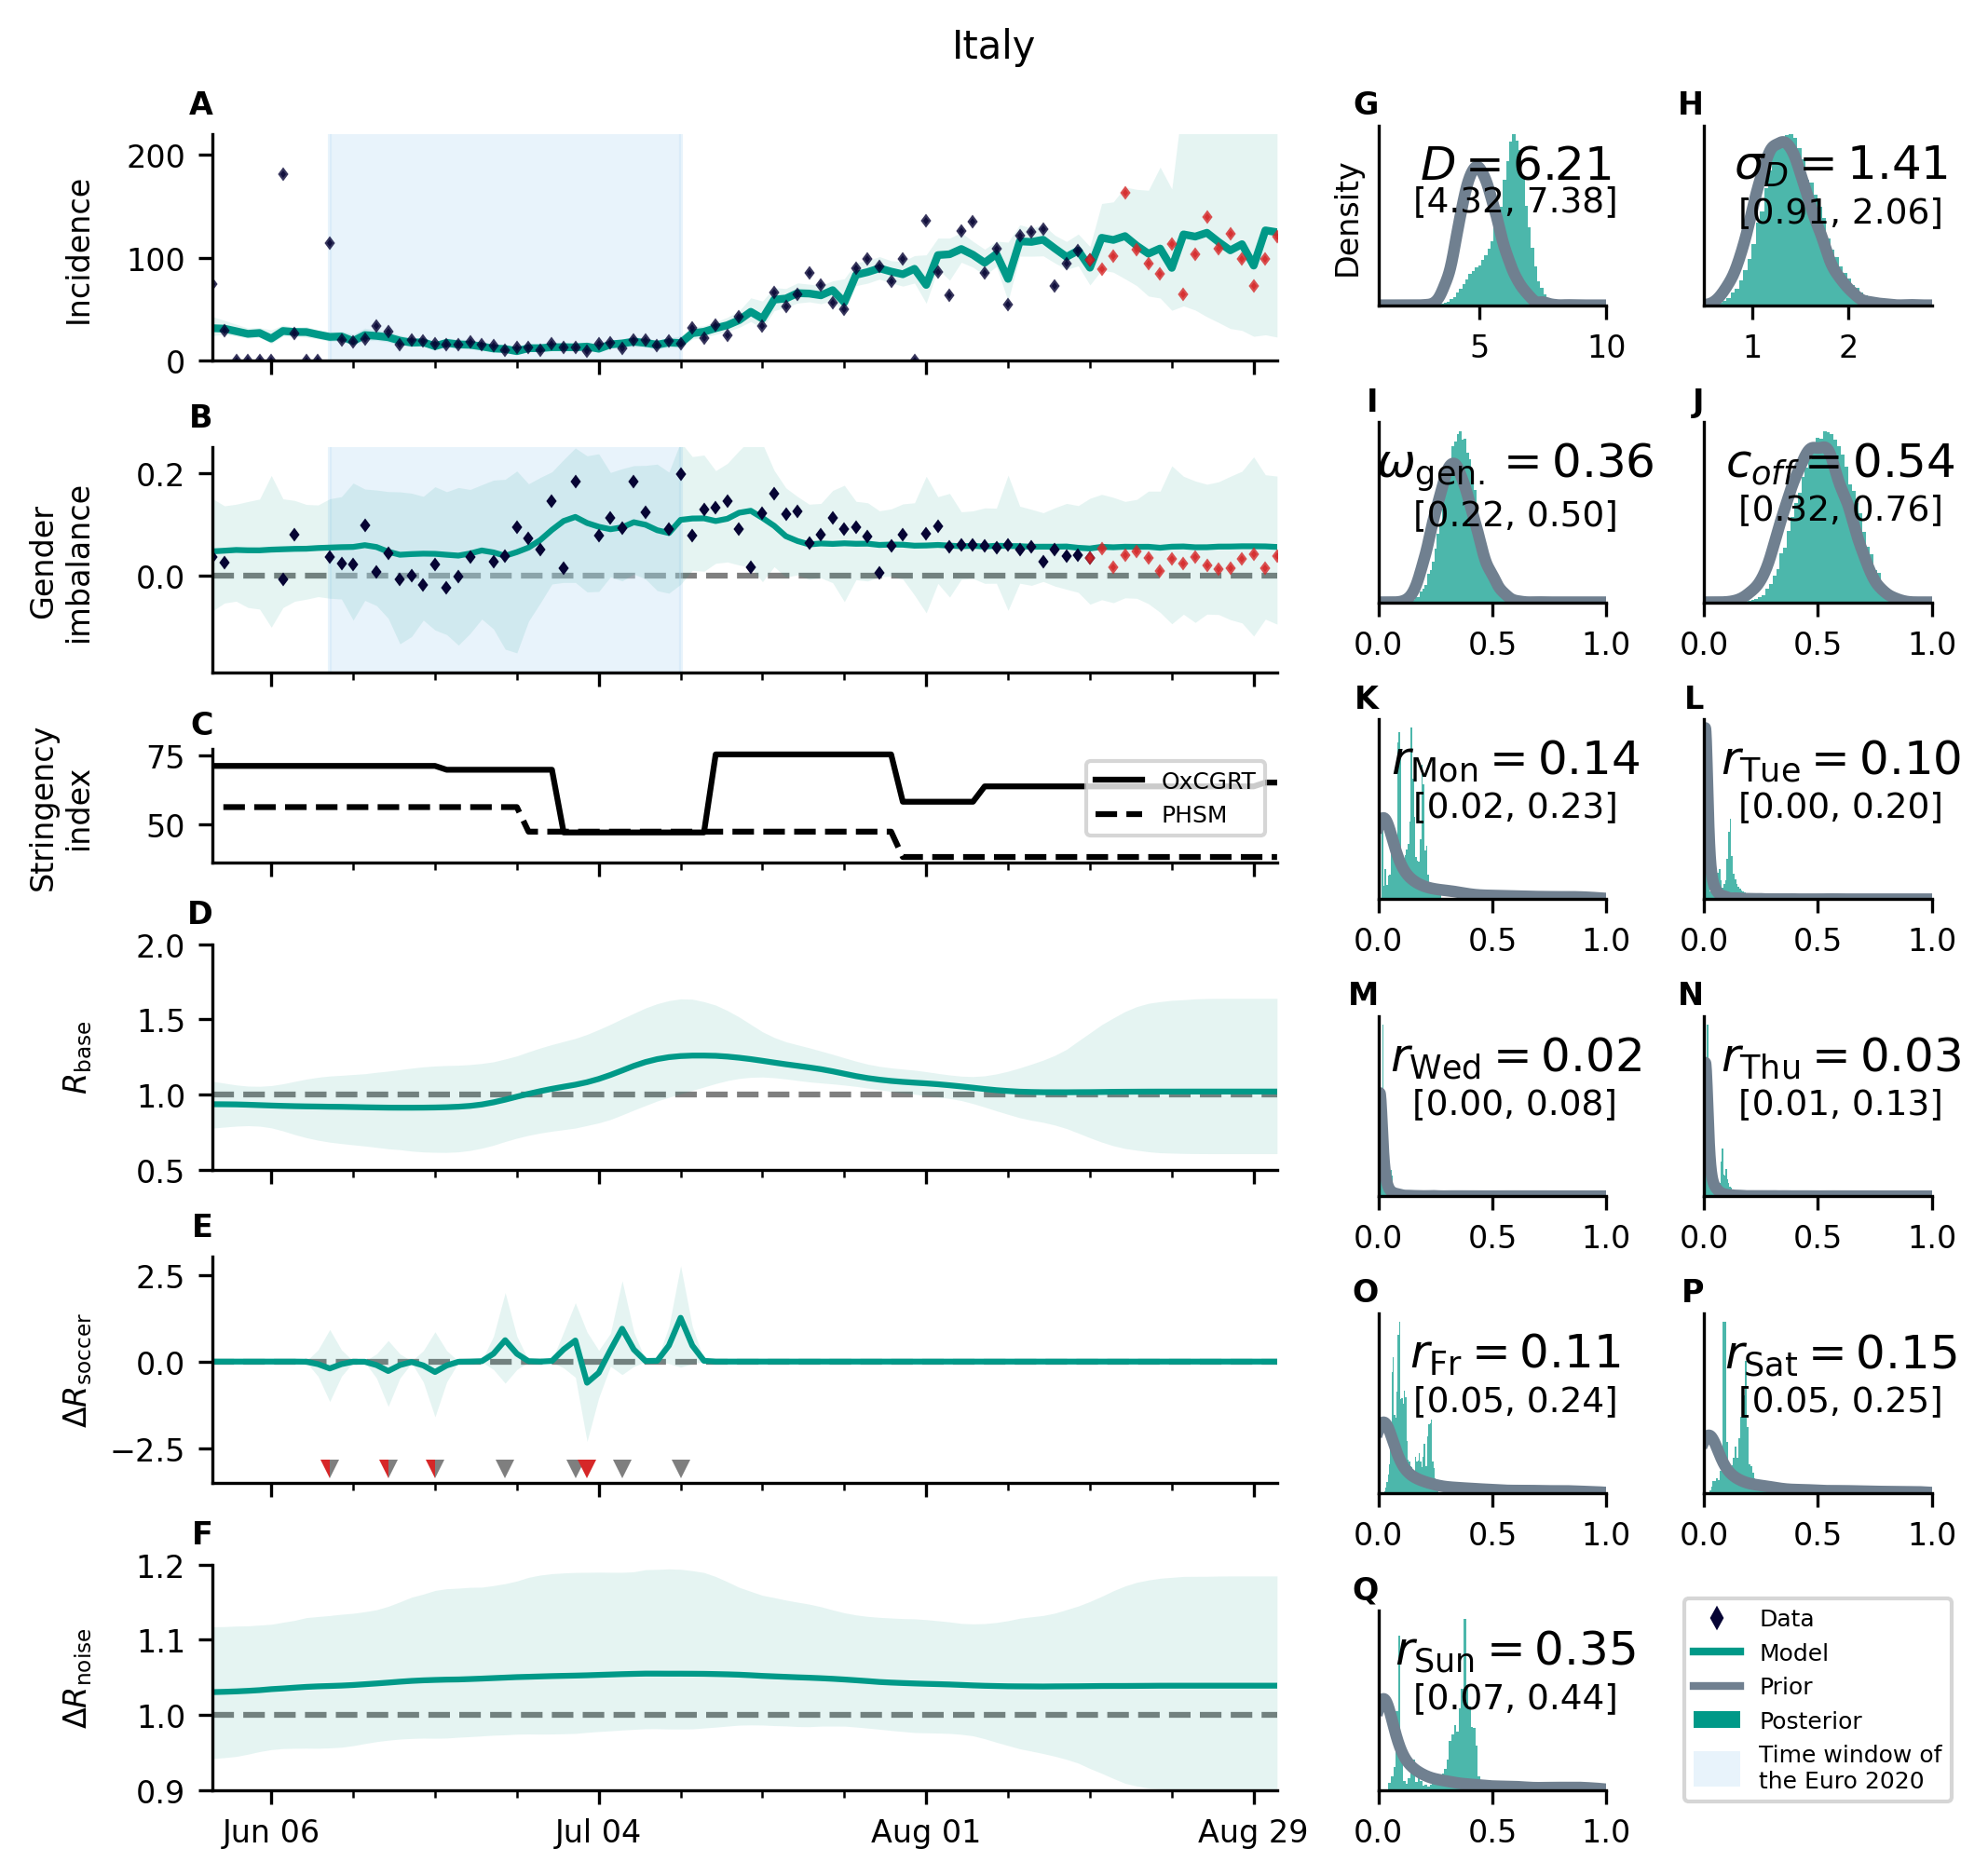

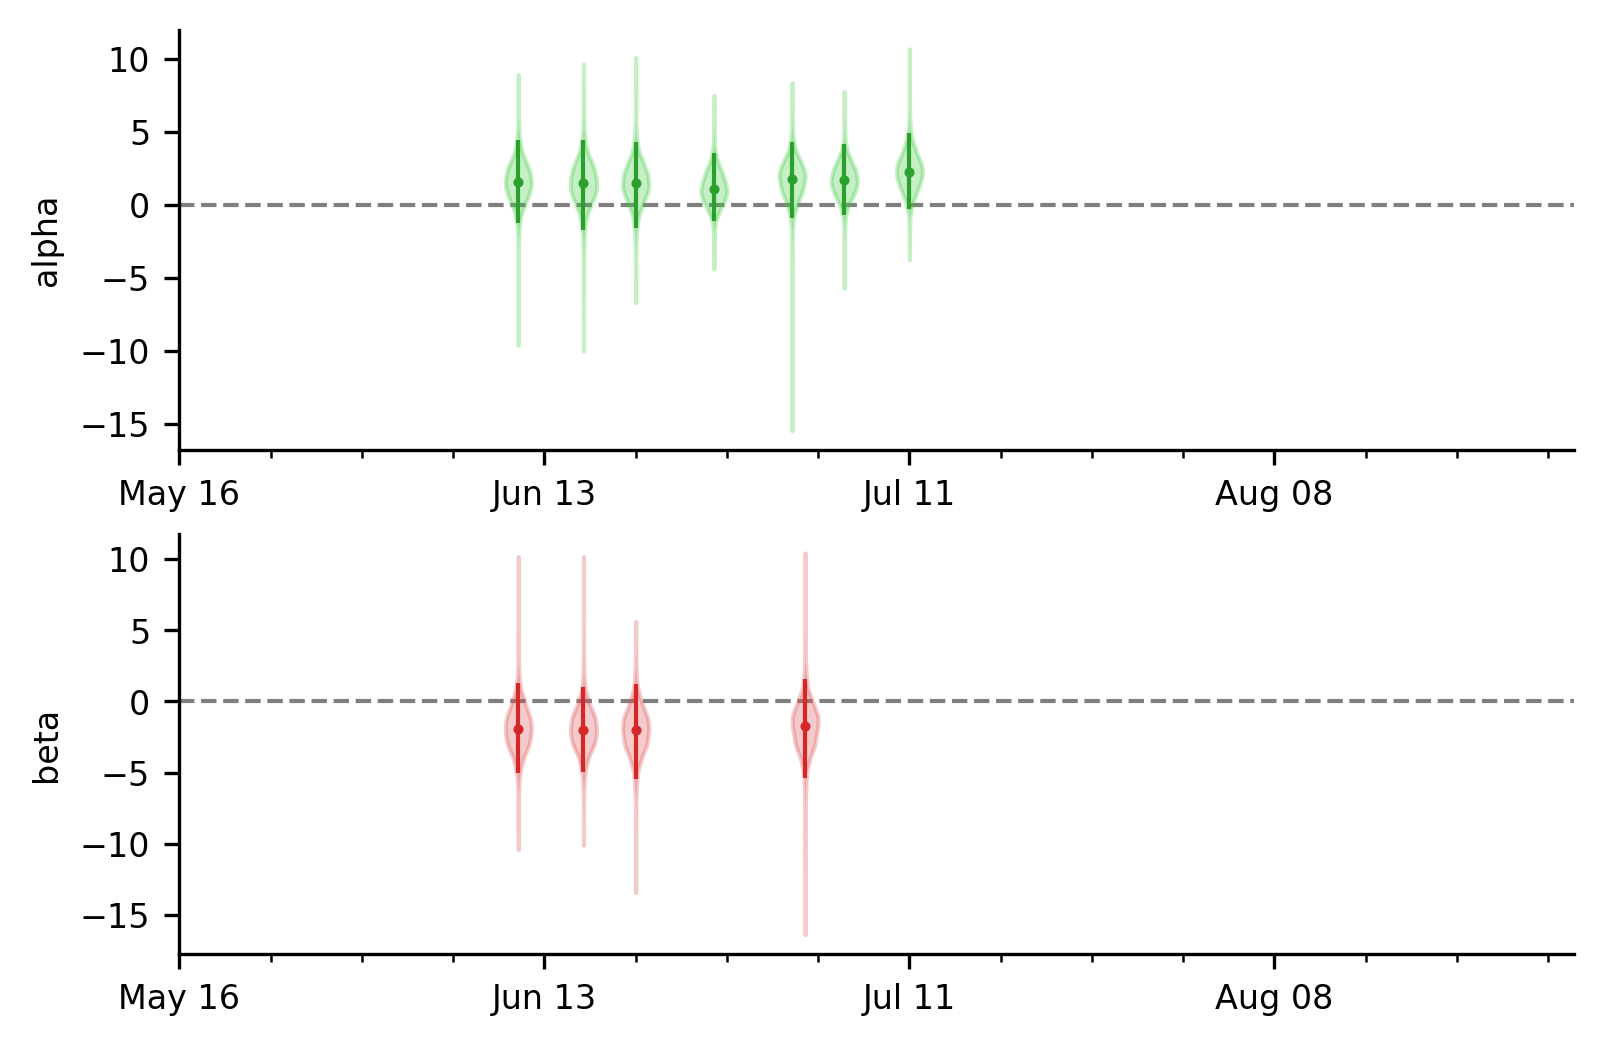

INFO     [covid19_inference.data_retrieval.retrieval] Successfully loaded OxCGRT.csv.gz from /tmp/covid19_data/, skipping download.
/home/smohr/Repositories/covid19_soccer/notebooks/supplementary/../../covid19_soccer/plot/other.py:920: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  lines.append(Patch([0], [0], color=rcParams.color_posterior, lw=0,),)


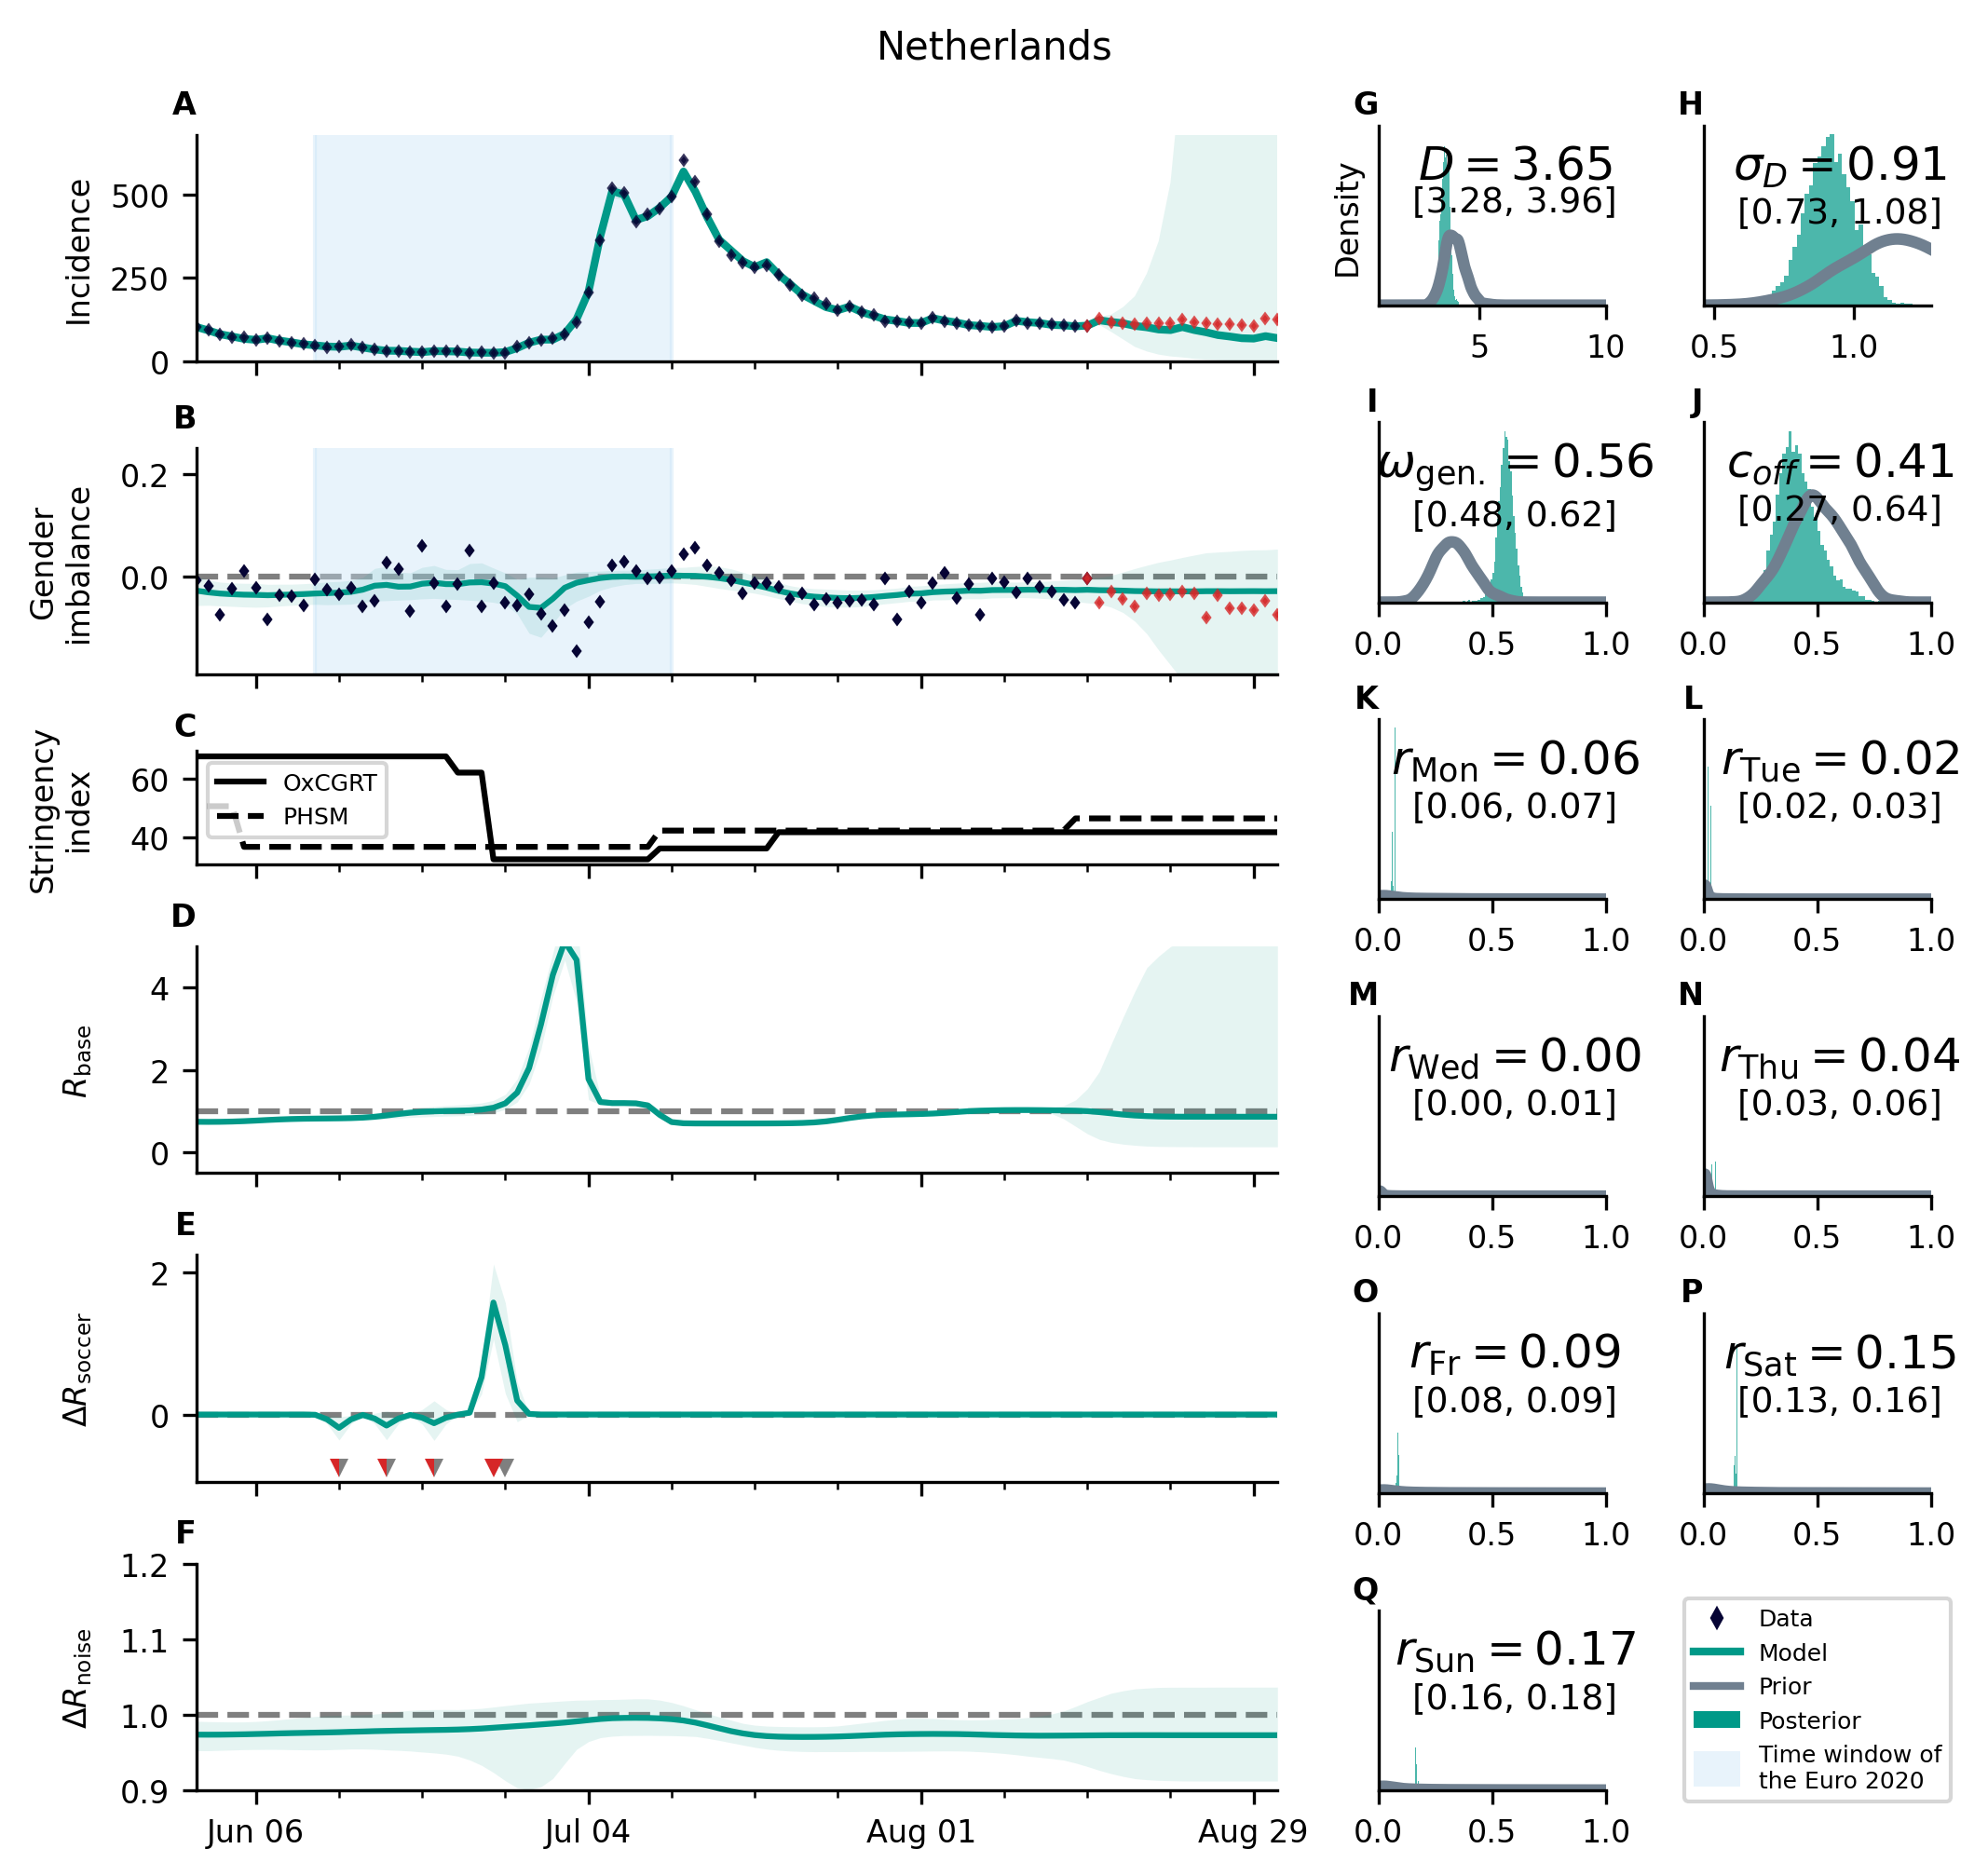

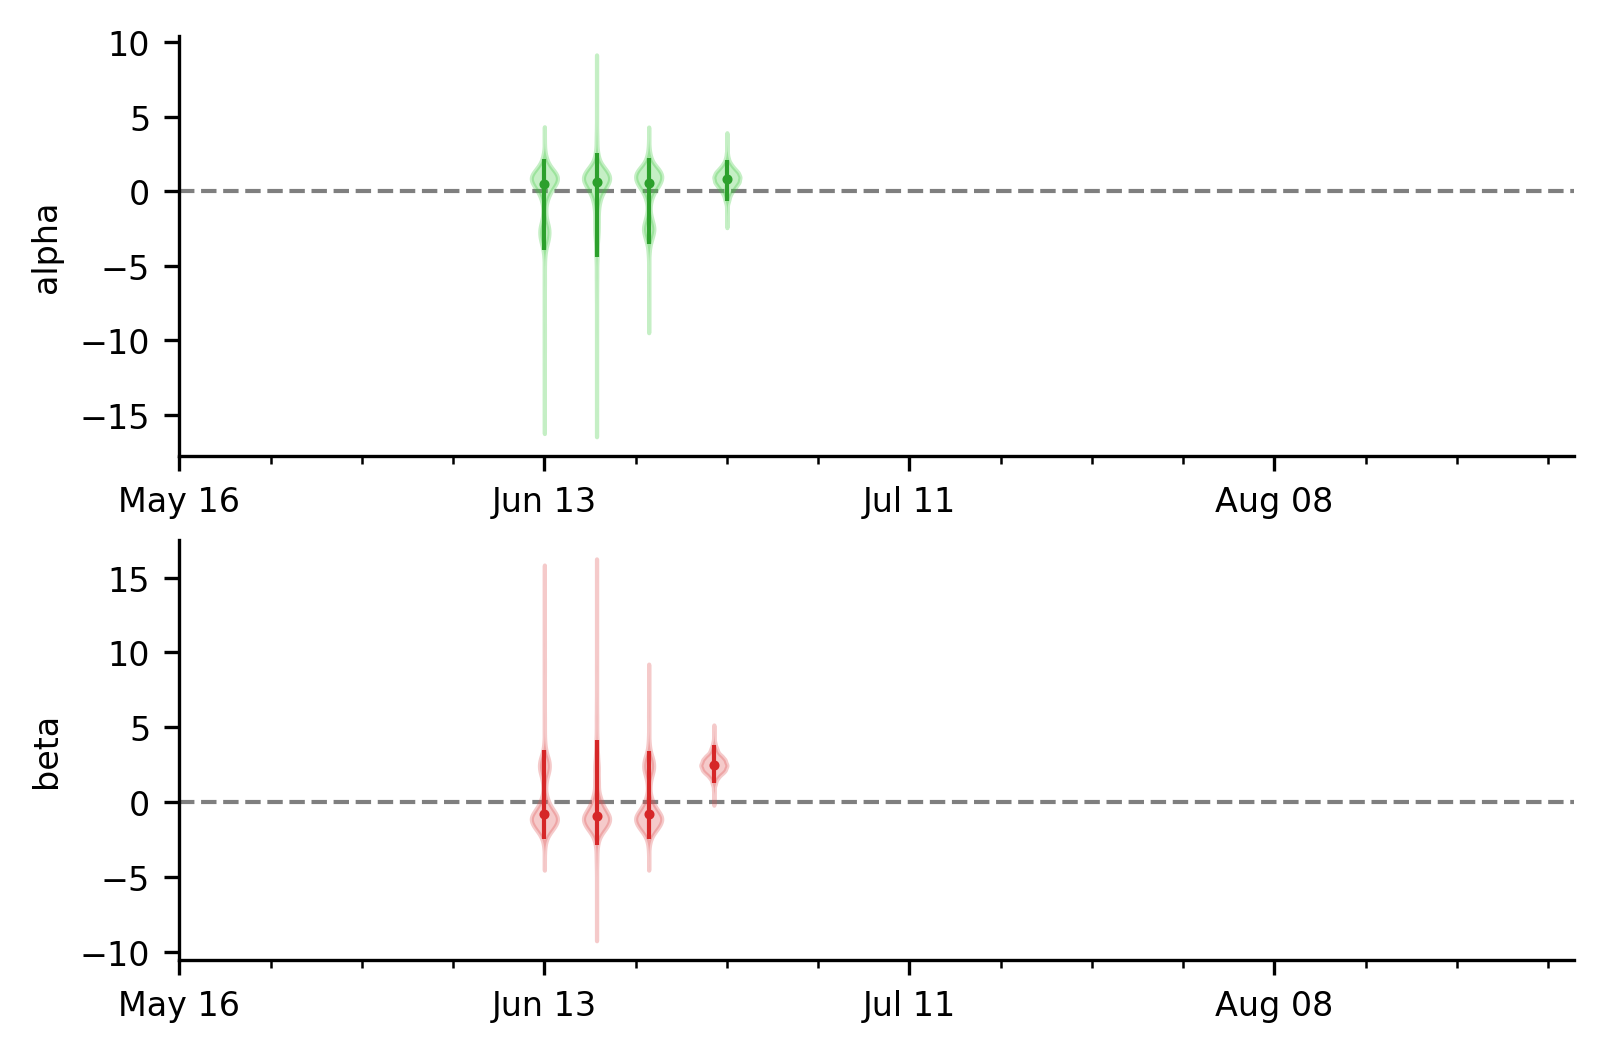

In [121]:
from covid19_soccer.plot.overview import single_extended,single_extended_v2
from covid19_soccer.plot.other import game_effects
from covid19_soccer.plot.utils import format_date_axis
"""
country2ylim_inbalance = {
    "England": [tr_spain,0.3],
    "Scotland": [-0.15,0.45],
    "Slovakia": [-0.6,0.6],
    "Italy": [-0.3,0.45],
    "Czechia": [-0.3,0.45]
}
"""
ylim_Imbalance = [-0.19,0.25]
ylim_Rnoise = [0.9,1.2]
ylim_Rbase = [0.5,2]

for trace,model,dl in zip(traces_edited,models,dls):
    
    country = dl.countries[0]
    if country == "Netherlands":
        ylim_rbase = [-0.5,5]
    else:
        ylim_rbase = ylim_Rbase
    
    if country == "Scotland":
        ylim_imbalance = [-0.19,0.46]
    else:
        ylim_imbalance = ylim_Imbalance
        
    if country == "Italy":
        ylim_incidence=[0,220]
    else:
        ylim_incidence=None
        
    fig0 = single_extended_v2(
        trace,
        model,
        dl,
        ylim_imbalance=ylim_imbalance,
        ylim_incidence=ylim_incidence,
        ylim_rnoise=ylim_Rnoise,
        ylim_rbase=ylim_rbase,
        show_hosted=True
    )
    if country == "Czechia":
        country = "Czech Republic"
    fig0.suptitle(f"{country}")

    fig0.savefig(
        f"../figures/SI/extended_overview/extended_overview_{dl.countries[0]}.pdf",
        transparent=True,
        dpi=300,
        bbox_inches='tight'
    )
    fig0.savefig(
        f"../figures/SI/extended_overview/extended_overview_{dl.countries[0]}.png",
        transparent=True,
        dpi=300,
        bbox_inches='tight'
    )
    plt.show()
    plt.close(fig=fig0)

    
    # Plot alpha
    # Plot beta
    fig,axes = plt.subplots(2,1,figsize=(6,4))
    game_effects(
        axes[0],
        trace,
        model,
        dl,
        color="tab:green",
        key="alpha"
    )
    format_date_axis(axes[0])
    axes[0].set_ylabel("alpha")
    game_effects(
        axes[1],
        trace,
        model,
        dl,
        color="tab:red",
        key="beta"
    )
    format_date_axis(axes[1])
    axes[1].set_ylabel("beta")
    axes[0].set_xlim(model.sim_begin, model.sim_end)
    axes[1].set_xlim(model.sim_begin, model.sim_end)
    plt.show()
    plt.close(fig=fig)  
    